In [14]:
import multiprocessing as mp                                                                                                                                                                                       
import os                                                                                                                                                                                                          
import numpy as np                                                                                                                                                                                                 
import awkward as ak                                                                                                                                                                                               
import matplotlib.pyplot as plt                                                                                                                                                                                    
import matplotlib                                                                                                                                                                                                  
import matplotlib.colors as colors                                                                                                                                                                                 
from tools.roottree import read_tree                                                                                                                                                                               
from tools.selections import *                                                                                                                                                                                     
from tools.constants import MC_PARTICLE_CHARGES, MC_PARTICLE_IDS, ISOTOPES_COLOR, ISO_LABELS                                                                                                                                          
from tools.binnings_collection import mass_binning, Rigidity_Analysis_Binning_FullRange                                                                                                                         
from tools.binnings_collection import get_nbins_in_range, get_sub_binning, get_bin_center, fbinning_energy                                                                                                            
from tools.calculator import calc_mass, calc_ekin_from_beta, calc_betafrommomentom, calc_beta_from_ekin                                                                                                                           
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, plot1d_step, FONTSIZE, set_plot_defaultstyle                               
from collections.abc import MutableMapping                                                                                                                                                                       
from tools.corrections import shift_correction                                                                                                                                                                     
import uproot                                                                                                                                                                                                      
from scipy import interpolate                                                                                                                                                                                      
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, get_corrected_lipbeta_agl, get_index_correction_agl                                                                                  
import ROOT                                                                                                                                                                                                        
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F                                                                                                                                                     
from ROOT import gROOT, gBenchmark, gRandom, gSystem                                                                                                                                                               
from tools.functions import gaussian, asy_gaussian, poly, asy_gaussian_1d                                                                                                                                          
uproot.default_library                                                                                                                                                                                             
from iminuit import Minuit                                                                                                                                                                                         
from iminuit.cost import ExtendedBinnedNLL, LeastSquares                                                                                                                                                           
from iminuit.util import describe, make_func_code                                                                                                                                                                  
from tools.constants import ISOTOPES, NUCLEI_NUMBER, DETECTOR_COLOR, ANALYSIS_RANGE_EKIN
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES
from tools.histograms import WeightedHistogram, Histogram, plot_histogram_2d, plot_histogram_1d                                                                                                                    
from tools.binnings import Binning, make_lin_binning                                                                                                                                                               
from tools.graphs import MGraph, plot_graph, get_nppolyfit                                                                                                                                                         
from scipy.interpolate import UnivariateSpline  
from scipy.optimize import curve_fit
from tools.utilities import power_law_v2, power_law, fit_flux
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs

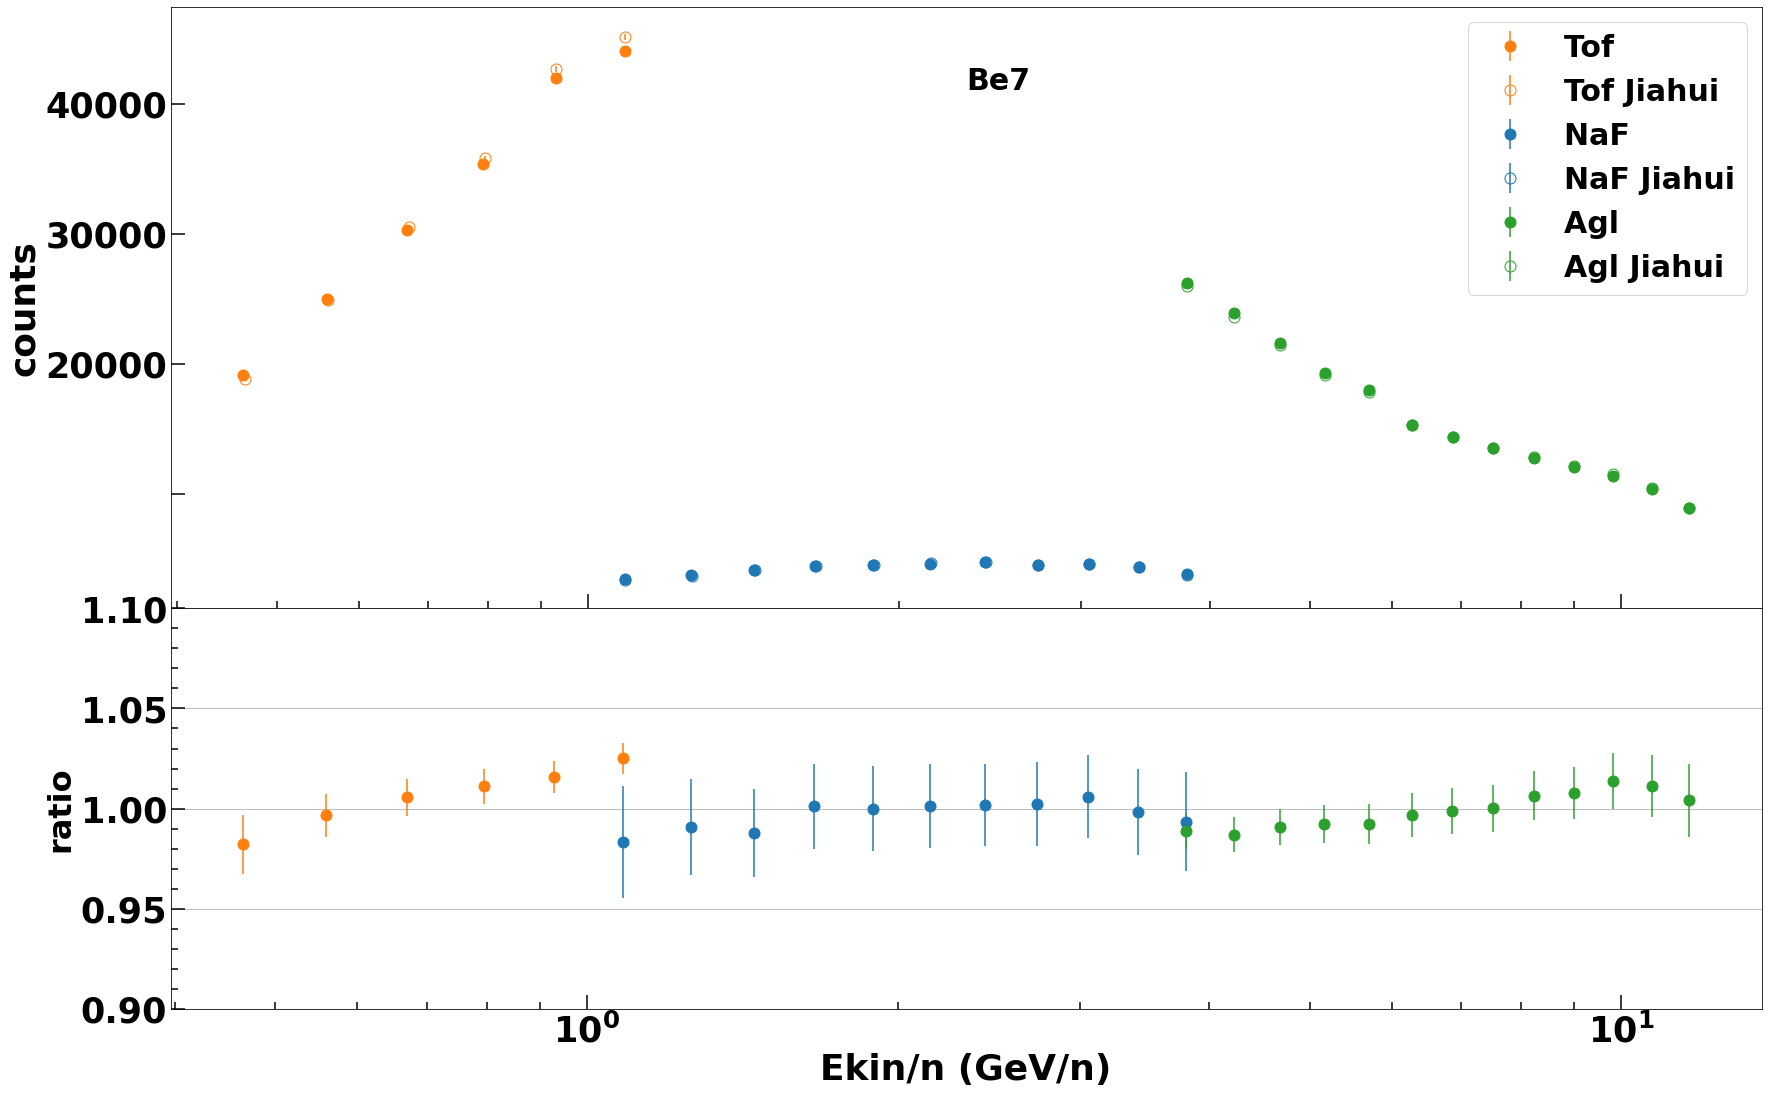

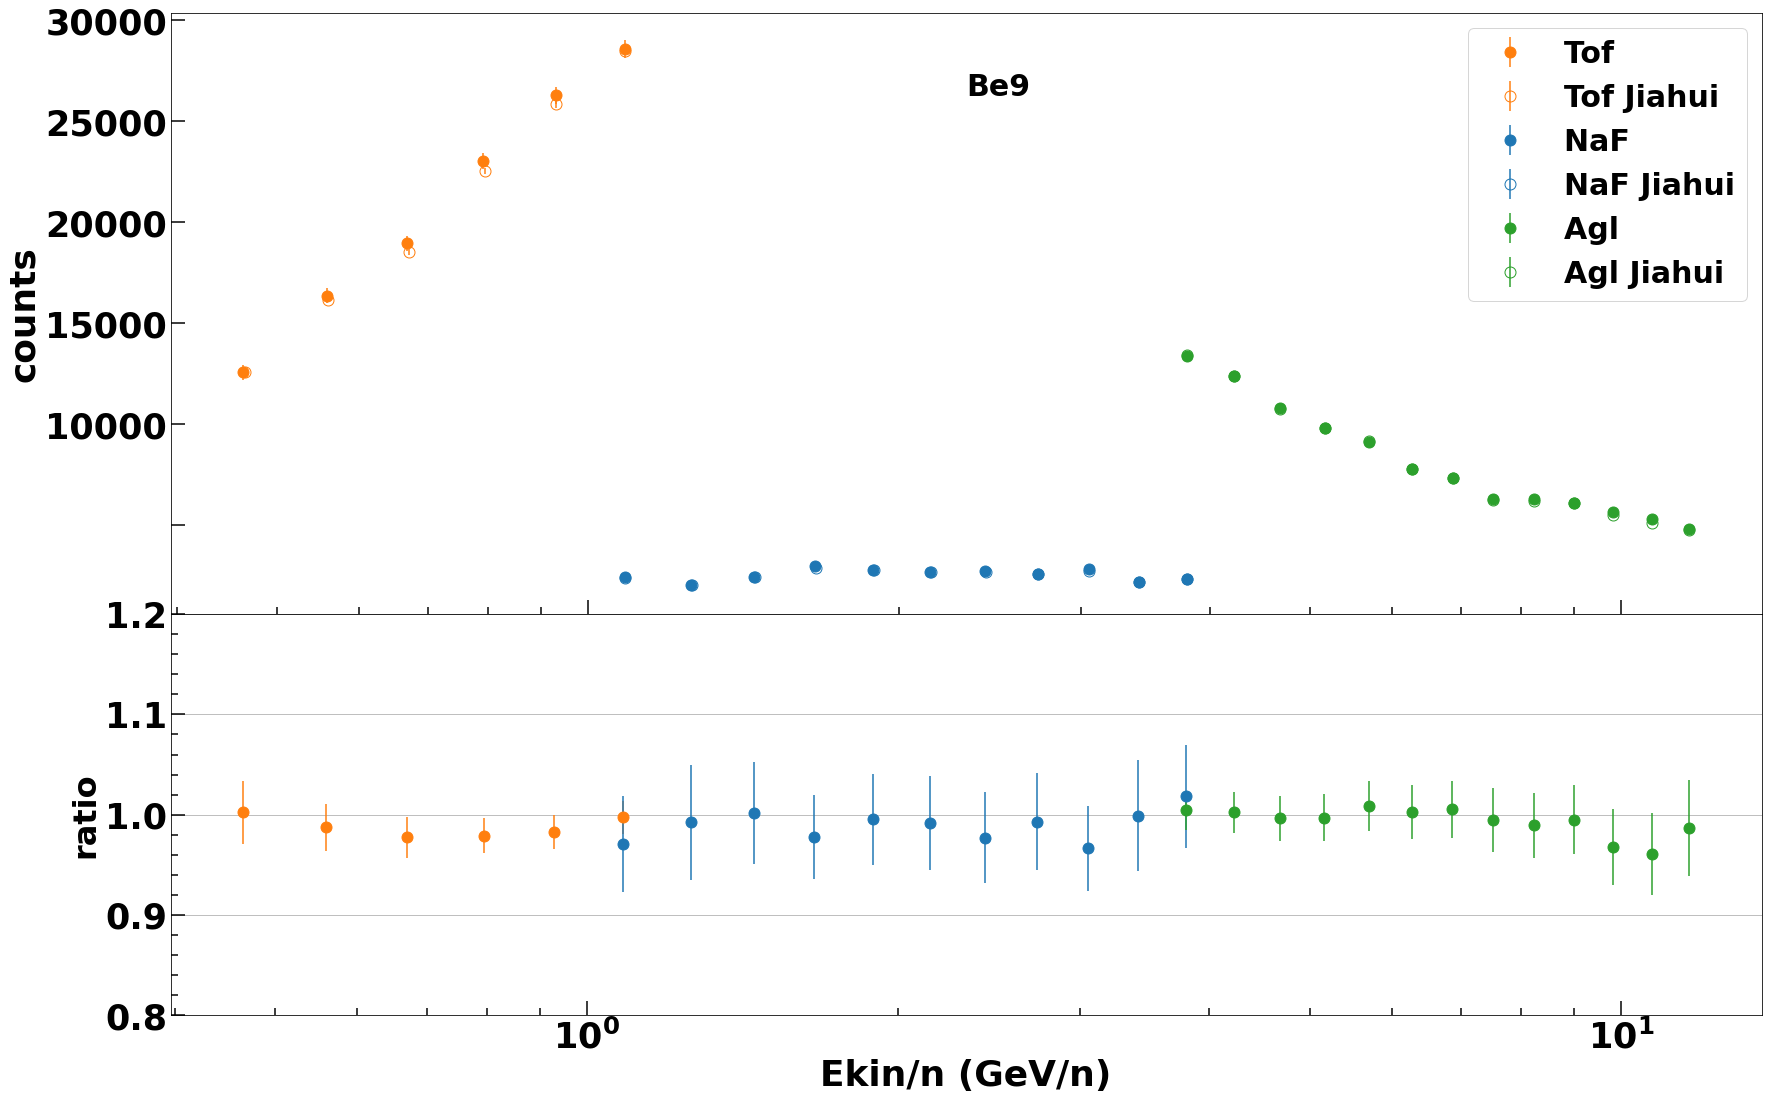

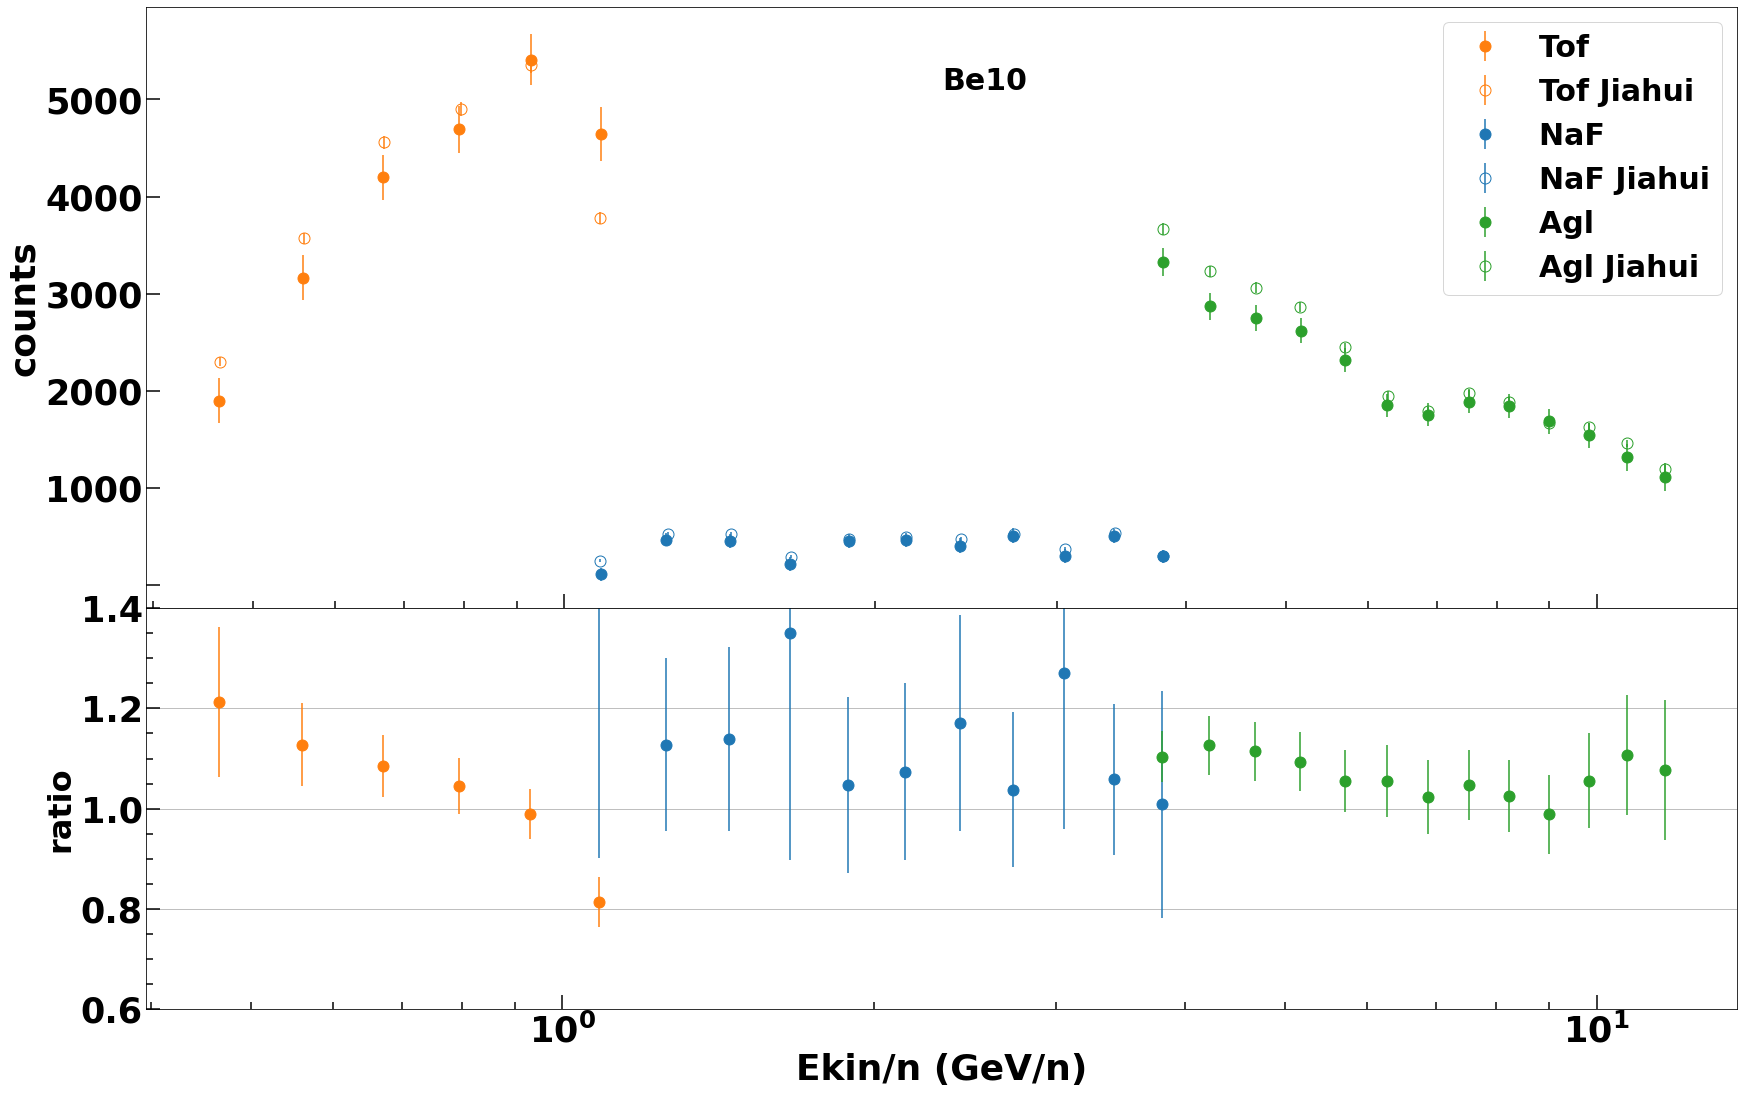

In [15]:
import pandas as pd 
detectors_alias = {"Tof":"tof", "NaF":"naf", "Agl": "agl"} 
detectors = ["Tof", "NaF", "Agl"]
isotopes = ["Be7", "Be9", "Be10"]
slicevalue ={'Tof':[0.45, 1.1], 'NaF':[1.0, 4.0], 'Agl':[4.0, 12.0]}
temp = 'Be7'
ratiolim = {'Be7':[0.9, 1.1], 'Be9':[0.8, 1.2], 'Be10':[0.6, 1.4]}

filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v20_s4sig_fix/graph_massfit_counts.npz'
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v20_s4sig_fix/'
filename_compare = '/home/manbing/Documents/Data/jiahui/MC_Events/BeMC_histmass_vsekin_jiahuicommsel_test.npz'
#filename_init = '/home/manbing/Documents/Data/data_mc/dfile/BeMC_dict_hist_mass_ekin.npz'
graph_counts_jiahui = {dec: dict() for dec in detectors}                                                                                                                                                    
for dec in detectors:                                                                                                                                                                                       
    jiahui_counts_file =  pd.read_csv(f"/home/manbing/Documents/Data/jiahui/isotope_fluxes/Event_Counts_from_Fit/nevt_{detectors_alias[dec]}_10yr.txt",  sep='\s+', header=0)                               
    for iso in isotopes:                                                                                                                                                                            
        xjiahuicounts = 0.5*(jiahui_counts_file['Ek_low'] + jiahui_counts_file['Ek_high'])                                                                                                                  
        graph_counts_jiahui[dec][iso] = MGraph(xjiahuicounts, jiahui_counts_file[f'T{temp}_N{iso}'], np.sqrt(jiahui_counts_file[f'T{temp}_N{iso}']))   
    

df_counts = np.load(f'{filename}')
#df_counts_compare = np.load(f'{filename_init}')
detectors = ['Tof', 'NaF', 'Agl']
isotopes = ["Be7", "Be9", "Be10"]
figSize = (22, 15)


graph_counts_fromfit = {dec: {} for dec in detectors}
graph_counts_compare = {dec: {} for dec in detectors}
graph_counts_sum = dict()
graph_counts_sum_compare = dict()
hist_mass2d = {dec: {} for dec in detectors}
xbinning = Binning(fbinning_energy())

for dec in detectors:
    for iso in isotopes:
        graph_counts_fromfit[dec][iso] = MGraph.from_file(df_counts, f"graph_counts_{dec}Opt{temp}_{iso}")
        graph_counts_fromfit[dec][iso] = slice_graph_by_value(graph_counts_fromfit[dec][iso], slicevalue[dec])
        #hist_mass2d[dec][iso] = WeightedHistogram.from_file(df_counts_compare, f"{iso}MC_{dec}_mass")
        #graph_counts_compare[dec][iso] = MGraph(xbinning.bin_centers[1:-1], np.sum(hist_mass2d[dec][iso].values[1:-1, 1:-1], axis=1), np.sqrt(np.sum(hist_mass2d[dec][iso].values[1:-1, 1:-1], axis=1)))
        #graph_counts_compare[dec][iso] = MGraph.from_file(df_counts_compare, f'{dec}_{iso}MC_counts')
        xstart = graph_counts_fromfit[dec][iso].xvalues[0]
        xend = graph_counts_fromfit[dec][iso].xvalues[-1]
        graph_counts_compare[dec][iso] = slice_graph_by_value(graph_counts_jiahui[dec][iso], np.array([xstart, xend]))
for iso in isotopes: 
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(26, 16))                                                                                                            
    fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
    for dec in detectors:
        plot_graph(fig, ax1, graph_counts_fromfit[dec][iso], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec} ')  
        plot_graph(fig, ax1, graph_counts_compare[dec][iso], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec} Jiahui', markerfacecolor="none") 
        #if dec == "Agl" and iso == "Be9":                                                                                                                                                            
        #    print(dec, iso)                                                                                                                                                                          
        #    print(graph_counts_fromfit[dec][iso])  
        graph_ratio = graph_counts_compare[dec][iso]/graph_counts_fromfit[dec][iso]
        plot_graph(fig, ax2, graph_ratio, color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec}')  
        if iso == "Be7":
            graph_counts_sum[dec] = graph_counts_fromfit[dec][iso]
            graph_counts_sum_compare[dec] = graph_counts_compare[dec][iso]
        else:
            graph_counts_sum[dec] = graph_counts_sum[dec] + graph_counts_fromfit[dec][iso]
            graph_counts_sum_compare[dec] = graph_counts_sum_compare[dec] + graph_counts_compare[dec][iso]
    ax2.set_ylim(ratiolim[iso])  
        
    ax2.grid(axis='y')
    ax2.set_xlabel('Ekin/n (GeV/n)') 
    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_xticklabels([])
    plt.subplots_adjust(hspace=.0)   
    ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_ylabel('counts')

    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_xticklabels([])

    plt.subplots_adjust(hspace=.0)   
    ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.set_ylabel('ratio', fontsize=32)
    
    #ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax2.set_xticks(np.array([2, 4, 10]))
    ax1.text(0.5, 0.9, f'{iso}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
    savefig_tofile(fig, plotdir, f"compare_counts_fromfit_T{temp}N{iso}_v23fix", show=True) 

In [16]:
with uproot.open("/home/manbing/Documents/Data/expo_time/expo_time_sf_finebin_10yr.root") as filetime:                                                                                                      
    hist_time_test = filetime[f'h_expo_rig_1_be7_bina7']                                                                                                                                                    
    yexpotime = hist_time_test.values()                                                                                                                                                                     
    xvalue_time = hist_time_test.axes[0].edges() 
    graph_measuretime = MGraph(get_bin_center(xvalue_time), yexpotime, np.zeros_like(yexpotime)) 
    

/home/manbing/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/manbing/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


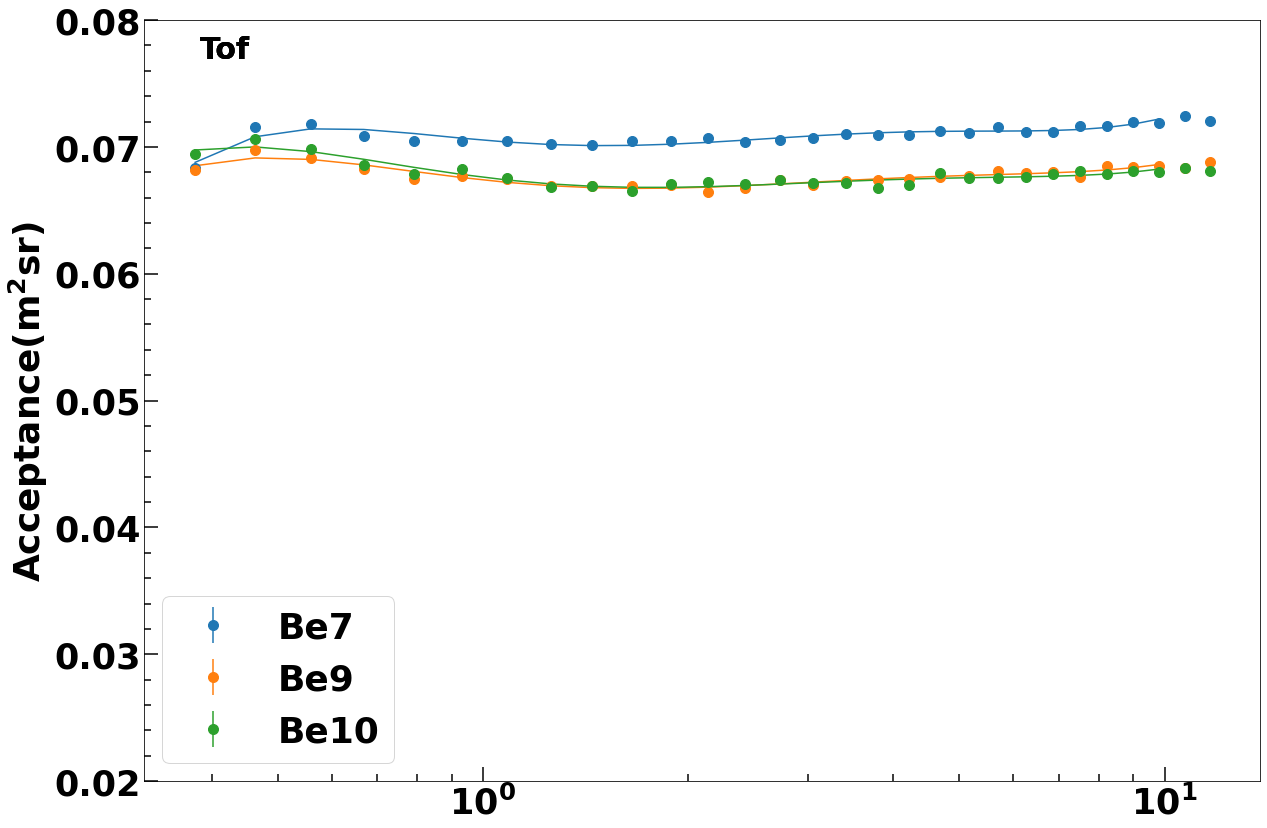

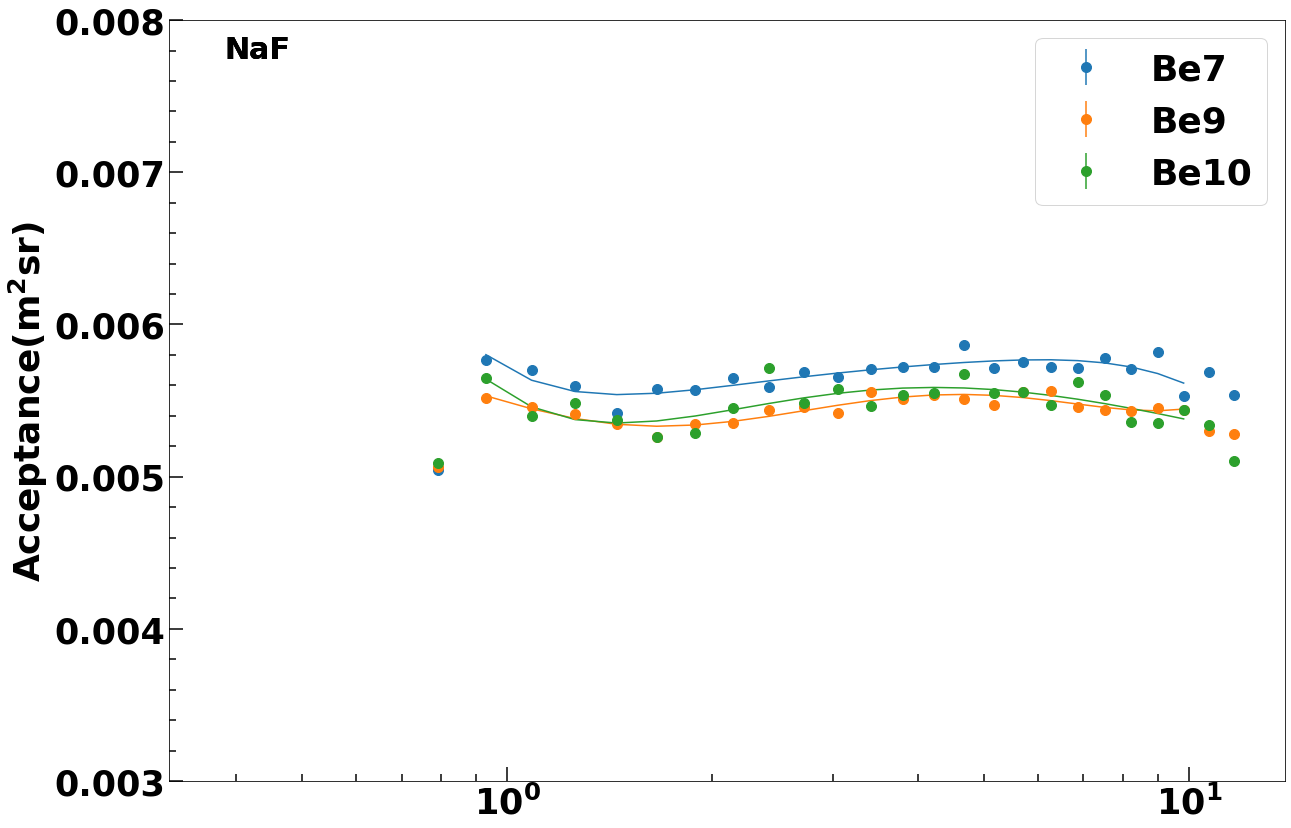

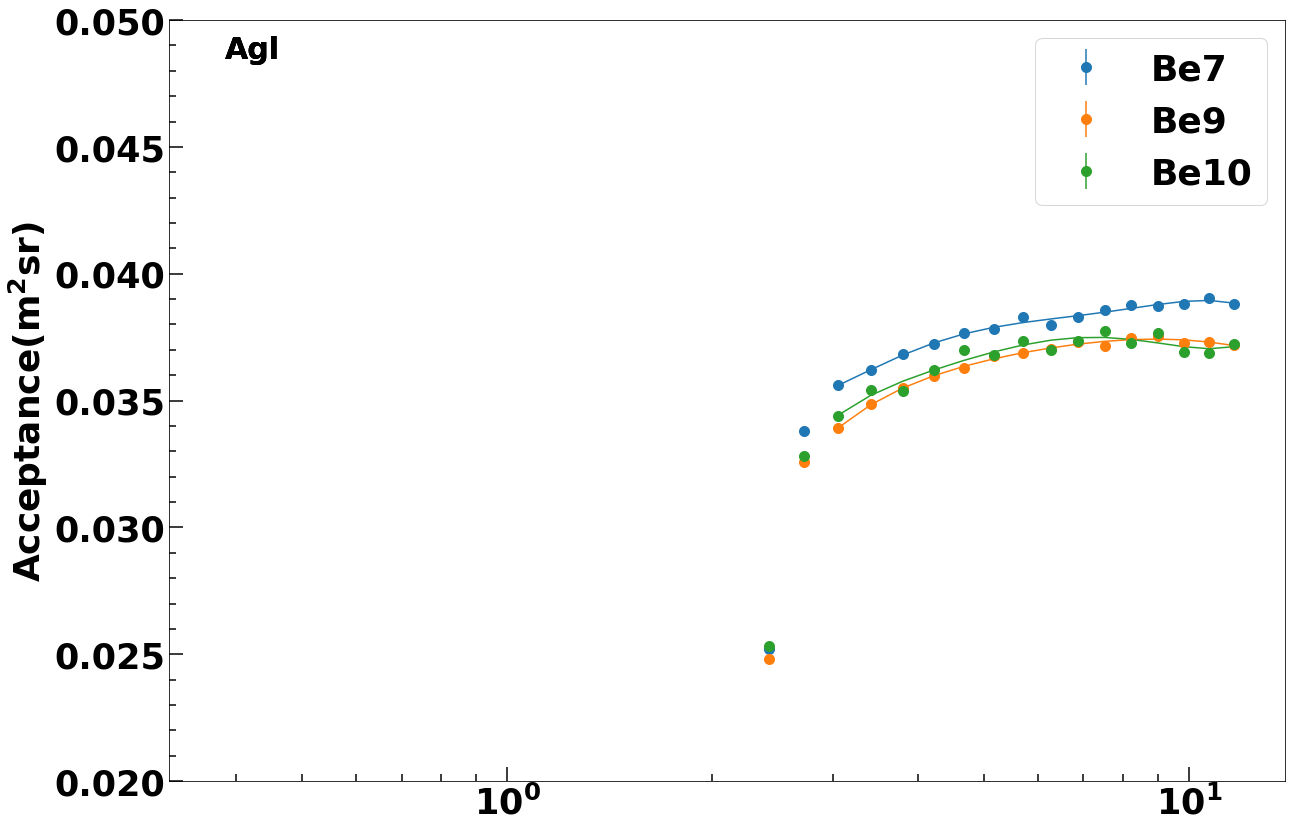

In [17]:
detectors = ['Tof', 'NaF', 'Agl']
isotopes = ["Be7", "Be9", "Be10"]
from tools.utilities import get_spline_from_graph, save_spline_to_file, get_graph_from_spline, get_spline_from_file
datadir = '/home/manbing/Documents/Data/data_be_flux'
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitBeryllium_v6/flux'
variable = 'Ekin'
nuclei = 'Be'

with np.load(os.path.join(datadir, f"BeMC_dict_graph_rawacc_{variable}.npz")) as file_acc:                                                                                                                
    graph_acc = {dec: {iso: MGraph.from_file(file_acc, f"raw_acc_{dec}_{iso}") for iso in ISOTOPES[nuclei]} for dec in detectors}                                                                              
    
ylim_range = {'Tof': [0.02, 0.08], "NaF": [0.003, 0.008], "Agl": [0.02, 0.05]}
xlim_range = {'Tof': [0.2, 10], 'NaF':[1.0, 10], "Agl":[3.0, 12]}
subgraph_acc =  {dec: {} for dec in detectors}
spline_subgraph_acc =  {dec: {} for dec in detectors}
graph_acc_fromspline = {dec: {} for dec in detectors}
for dec in detectors:                                                                                                                                                                                          
    figure, ax1 = plt.subplots(1, 1, figsize=(20, 14))                                                                                                        
    for i, iso in enumerate(ISOTOPES[nuclei]): 
        subgraph_acc[dec][iso] = slice_graph_by_value(graph_acc[dec][iso], xlim_range[dec])
        x_values = subgraph_acc[dec][iso].xvalues
        spline_subgraph_acc[dec][iso] = UnivariateSpline(np.log(subgraph_acc[dec][iso].xvalues),subgraph_acc[dec][iso].yvalues, k=5, s=5)  
        
        ax1.plot(x_values, spline_subgraph_acc[dec][iso](np.log(x_values)))
        #acc_corr = graph_acc[dec][iso].yvalues * graph_total_effcor_ekin[dec][iso].yvalues                                                                                                                     
        #graph_corrected_acc[dec][iso] = MGraph(xbinning["Ekin"].bin_centers[1:-1], acc_corr, graph_acc[dec][iso].yerrs)                                                                                                                                                                                                                                                                                                  
        plot_graph(figure, ax1, graph_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{iso}", style="EP", xlog=True, ylog=False, markersize=20)                                                                            
        #plot_graph(figure, ax1, graph_corrected_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{iso}", style="EP", xlog=True, ylog=False, markersize=20)                                                    
        ax1.legend()                                                                                                                                                                                                                                                                                                                                                                       
        ax1.set_xscale("log")   
        ax1.set_ylim(ylim_range[dec])
        ax1.set_ylabel(r"$\mathrm{Acceptance (m^{2} sr)}$")                                                                                                                                                    
        ax1.text(0.05, 0.98, f"{dec}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                                                                                                                                                                                           
    savefig_tofile(figure, plotdir, f"acc_{nuclei}_{dec}_{variable}", 1)

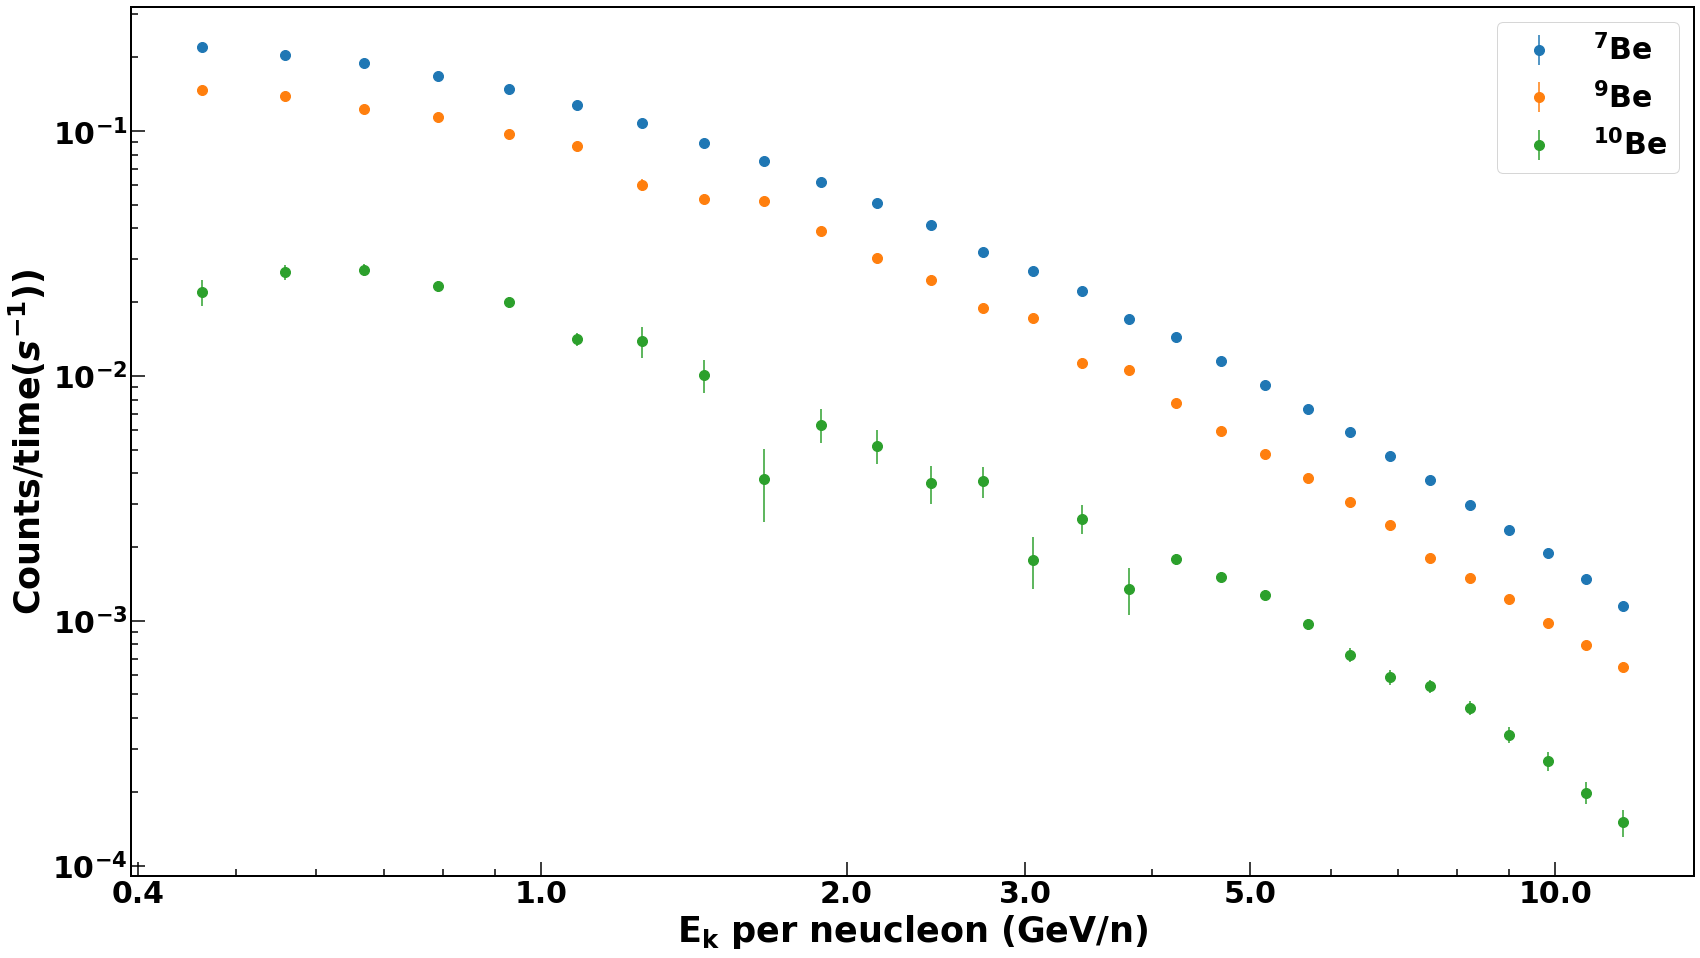

In [18]:
graph_rawflux = {dec: dict() for dec in detectors}  
graph_rawflux_combined = dict()
graph_measured_rate = {dec: dict() for dec in detectors} 
graph_measured_rate_combined = dict()
df_measure_rate = dict()
xbinning = {"Rigidity": Binning(fbinning_energy()), "Ekin":Binning(fbinning_energy())}   
for dec in detectors:                                                                                                                                                                                          
    for iso in ISOTOPES[nuclei]:                                                                                                                                                                               
        xenergy = graph_counts_fromfit[dec][iso].xvalues                                                                                                                                                               
        counts = graph_counts_fromfit[dec][iso].yvalues                                                                                                                                                                
        counts_err = graph_counts_fromfit[dec][iso].yerrs                                                                                                                                                              
        #effcor = slice_graph_by_value(graph_total_effcor_ekin[dec][iso], [xenergy[0], xenergy[-1]])                                                                                                            
        acc = spline_subgraph_acc[dec][iso](np.log(xenergy))  
        graph_acc_forerr = slice_graph_by_value(graph_acc[dec][iso], [xenergy[0], xenergy[-1]])  
        acc_err = graph_acc_forerr.yerrs
        time = slice_graph_by_value(graph_measuretime, [xenergy[0], xenergy[-1]])   
        
        meas_rate = counts/time.yvalues
        meas_rate_err = counts_err/time.yvalues
        graph_measured_rate[dec][iso] = MGraph(xenergy, meas_rate, meas_rate_err)
        graph_measured_rate[dec][iso].add_to_file(df_measure_rate, f'graph_measured_rate_{dec}{iso}')
        indices = xbinning['Ekin'].get_indices([xenergy[0], xenergy[-1]])                                                                                                                                    
        #bin_widths = xbinning[variable].bin_widths[indices[0]: indices[1]+1]                                                                                                                                  
        bin_edges = xbinning['Ekin'].edges[indices[0]: indices[1]+2]                                                                                                                                         
        bin_widths = bin_edges[1:] - bin_edges[:-1]                                                                                                                                                            
        #assert (np.all(xenergy == effcor.xvalues))                                                                                                                                                                                                                                                                                                                             
        assert (np.all(xenergy == time.xvalues))                                                                                                                                                               
        assert (np.all(xenergy == get_bin_center(bin_edges)))                                                                                                                                                  
        flux_raw = counts /(acc *time.yvalues * bin_widths)    
        
        flux_raw_err = flux_raw * np.sqrt((counts_err/counts)**2 + (acc_err/acc)**2)                                                                                                                         
        graph_rawflux[dec][iso] = MGraph(xenergy, flux_raw, flux_raw_err)                                                                                                                                                 
        #print(graph_flux_raw[dec][iso])
        
Range ={"Tof": [0.41, 1.1], "NaF":[1.2, 4.0], "Agl":[4.1, 12.0]}       
for iso in ISOTOPES[nuclei]:
    graph_rawflux_combined[iso] = concatenate_graphs(slice_graph_by_value(graph_rawflux["Tof"][iso], Range["Tof"]), slice_graph_by_value(graph_rawflux["NaF"][iso], Range["NaF"]))                                                                     
    graph_rawflux_combined[iso] = concatenate_graphs(graph_rawflux_combined[iso], slice_graph_by_value(graph_rawflux["Agl"][iso], Range["Agl"]))                                                                                                       
    graph_rawflux_combined[iso].add_to_file(df_measure_rate, f'graph_rawflux_combined_{iso}')
    graph_measured_rate_combined[iso] = concatenate_graphs(slice_graph_by_value(graph_measured_rate["Tof"][iso], Range["Tof"]), slice_graph_by_value(graph_measured_rate["NaF"][iso], Range["NaF"]))                                                                     
    graph_measured_rate_combined[iso] = concatenate_graphs(graph_measured_rate_combined[iso], slice_graph_by_value(graph_measured_rate["Agl"][iso], Range["Agl"]))                                                                                                       
    graph_measured_rate_combined[iso].add_to_file(df_measure_rate, f'graph_measuredrate_combined_{iso}')
np.savez(os.path.join('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold', 'df_meas_rate.npz'), **df_measure_rate)

fig, ax1 = plt.subplots(figsize=(28, 16))
for iso in ISOTOPES[nuclei]:
    plot_graph(fig, ax1, graph_rawflux_combined[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20, label=f"{ISO_LABELS[iso]}")
        
#plot_graph(fig, ax1, graph_predict_rate, color='black', style="EP", xlog=True, ylog=False, markersize=20, label=f"intergrate")
ax1.set_ylabel(r"$\mathrm{Counts/time} (s^{-1})) }$", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_defaultstyle(ax1)   
ax1.legend()
savefig_tofile(fig, plotdir, 'be_isoflux', 1)

[0.2014084  0.19734187 0.18615455 0.17009281 0.1511194  0.13123939
 0.11196158 0.09403465 0.07806643 0.06414171 0.05221704 0.04224719
 0.03405861 0.02736912 0.02193071 0.01755706 0.01404456 0.01122774
 0.00898344 0.00716917 0.00575362 0.00464401 0.0037357  0.00300043
 0.00240984 0.00193784 0.00156163 0.00126207]
[0.14297799 0.13715893 0.12670543 0.11344507 0.09881331 0.08419564
 0.07053797 0.05822489 0.04754807 0.03845734 0.03083929 0.02459545
 0.01956004 0.01551544 0.01227878 0.00971404 0.00768274 0.00607504
 0.00480998 0.00379943 0.00301985 0.00241522 0.00192529 0.00153261
 0.00122026 0.00097295 0.00077762 0.00062344]
[0.02855559 0.02671024 0.0241858  0.02134289 0.01841892 0.01562935
 0.01310167 0.01086728 0.00895162 0.00732798 0.00596603 0.00484339
 0.0039293  0.00318554 0.00258094 0.00209313 0.00169896 0.00138015
 0.00112341 0.00091325 0.00074696 0.00061464 0.00050456 0.0004139
 0.00033973 0.00027931 0.00023018 0.00019027]
{'Be7': {'phi': 0.6481041791251355, 'c': 0.0091039140254647

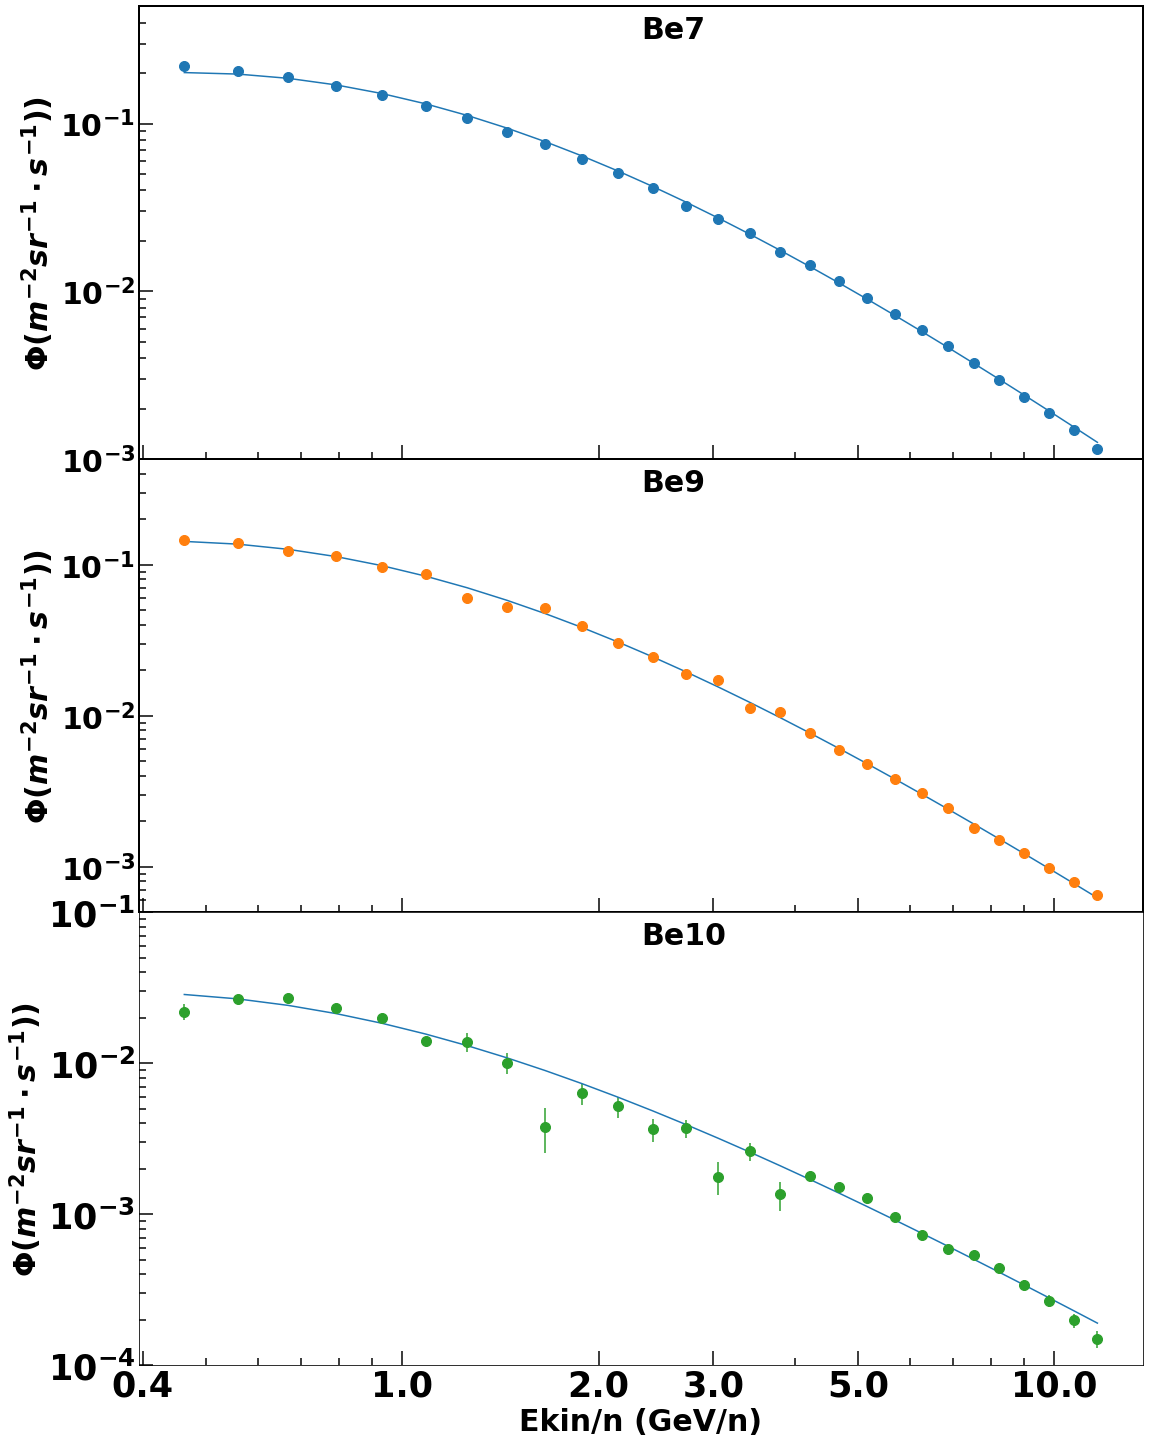

In [19]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/isotopesflux/thismc/Be_Isoflux.npz'
data = np.load(f'{filename}')
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/'
graph_flux = dict()
isoylim={'Be7': [0.001, 0.5], 'Be9':[0.0005, 0.5], 'Be10':[0.0001, 0.1]}
isoflux_powerlaw = dict()
isoflux_param_dict = dict()

guess_init = {'phi': 0.6481047734488288, 'c': 0.00910388990622317, 'rigidity_scale': 6.30008161547104, 'gamma': -2.793550533750972}
for iso in ISOTOPES['Be']:
    refflux_array = np.core.records.fromarrays((graph_rawflux_combined[iso].xvalues, graph_rawflux_combined[iso].yvalues, graph_rawflux_combined[iso].yerrs, graph_rawflux_combined[iso].yerrs), names=("rigidity", "flux", "flux_error_low", "flux_error_high"))
    isoflux_powerlaw[iso], isoflux_param_dict[iso]  = fit_flux(refflux_array,  "{iso}flux", function=power_law, guess=guess_init)
    print(isoflux_powerlaw[iso](graph_rawflux_combined[iso].xvalues))
    
print(isoflux_param_dict)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(18, 25))
ax = [ax1, ax2, ax3]
for i, iso in enumerate(ISOTOPES['Be']):
    ax[i].text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")
    ax[i].set_ylabel(r"$\mathrm{\Phi} (m^{-2} sr^{-1} \cdot s^{-1})) }$")   
    plot_graph(fig, ax[i], graph_rawflux_combined[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20)
    ax[i].set_ylim(isoylim[iso])    
    ax[i].plot(graph_rawflux_combined[iso].xvalues, isoflux_powerlaw[iso](graph_rawflux_combined[iso].xvalues), '-')
    
ax3.set_xlabel("Ekin/n (GeV/n)")     
ax3.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
ax1.sharex(ax3)   
ax2.sharex(ax3)

ax1.get_xticklabels()[0].set_visible(False)   
ax2.get_xticklabels()[0].set_visible(False) 
set_plot_defaultstyle(ax1)                                                                                                                                                                                 
set_plot_defaultstyle(ax2)   
plt.subplots_adjust(hspace=.0)
savefig_tofile(fig, plotdir, 'be_isoflux', 1)




xvalues			yvalues			yerrs
0.4631			0.001385693978506304			1.814289672990332e-05
0.5589999999999999			0.0015002883874120855			1.3296782522412246e-05
0.66835			0.0015645748765845133			1.138093148969711e-05
0.79125			0.0015515893148638556			1.0546965440149163e-05
0.9302999999999999			0.001561412553095477			9.55414922426596e-06
1.08555			0.001458760540250564			8.819688315426247e-06
1.2570999999999999			0.00010822488675734535			1.919491639034526e-06
1.44745			9.886087445153542e-05			1.5562266686085421e-06
1.6566			9.12184465920244e-05			1.3931267658266472e-06
1.8872			8.329428037107986e-05			1.2606745679775275e-06
2.1419			7.578113786278645e-05			1.1149090647961893e-06
2.42075			6.792821927705489e-05			9.780026603019354e-07
2.7237			5.724230331106603e-05			8.342889838331535e-07
3.0534			5.263998881567141e-05			7.753849047814207e-07
3.4126000000000003			4.743691720164058e-05			7.243753994663909e-07
3.8012500000000005			3.946100349951335e-05			7.393896028116862e-07
4.2221			0.000235852942024

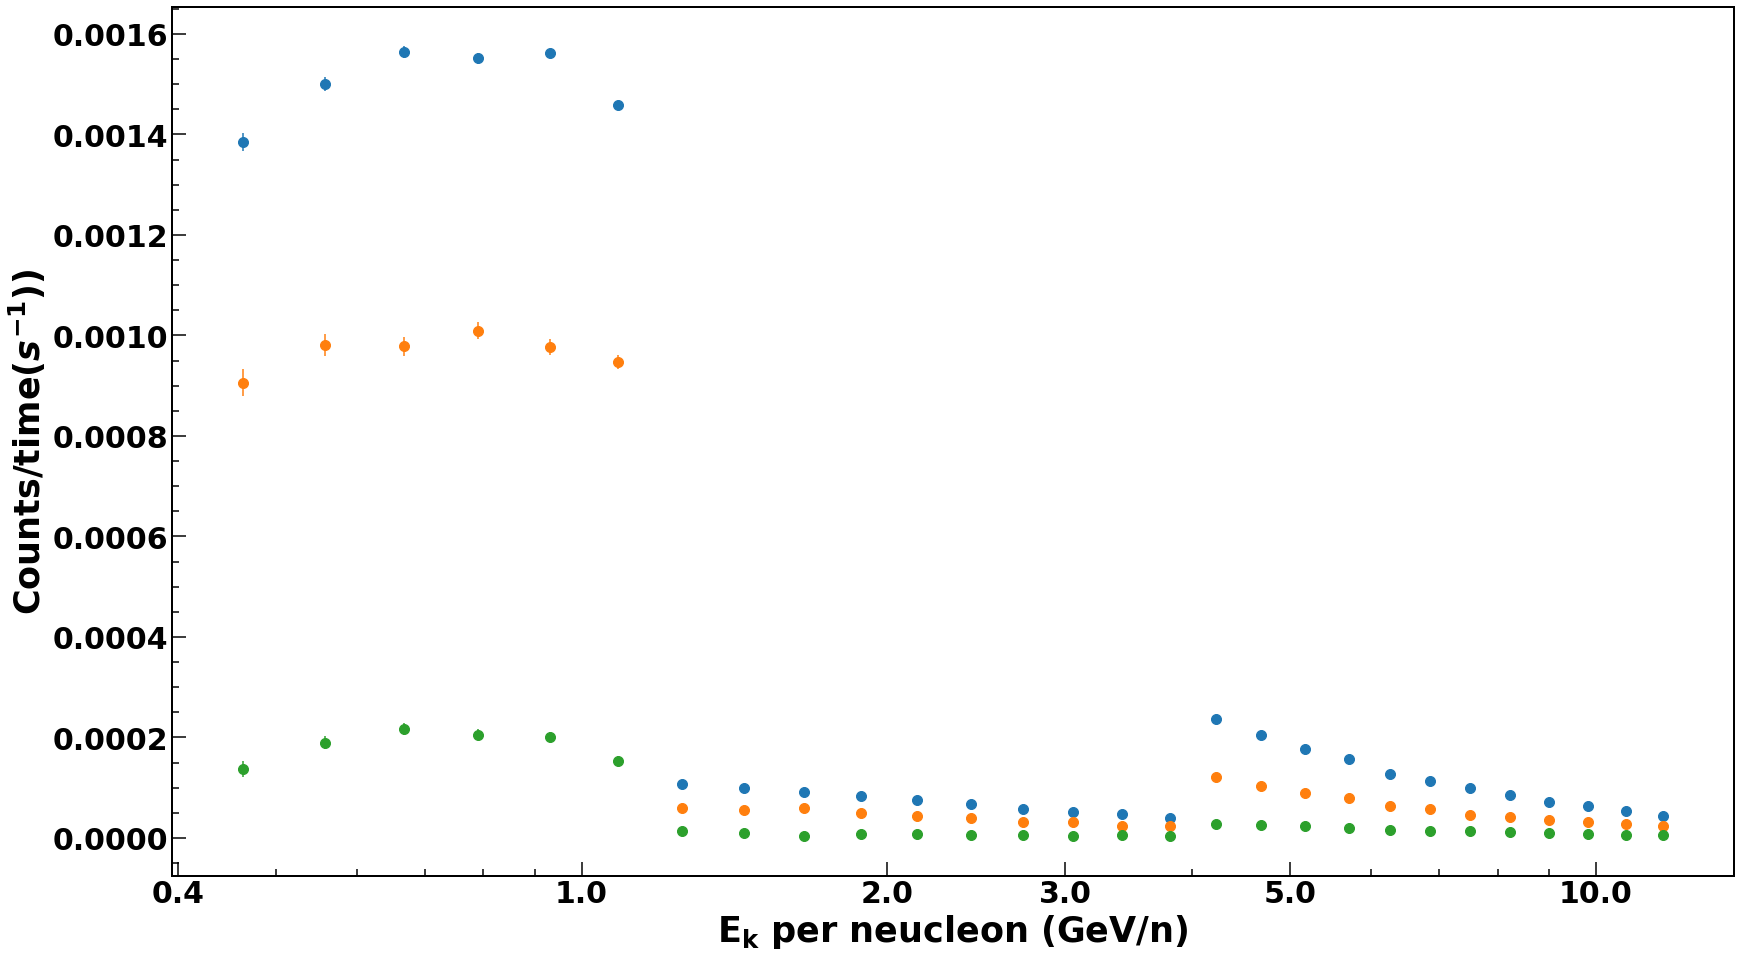

In [20]:
fig, ax1 = plt.subplots(figsize=(28, 16))
for iso in ISOTOPES[nuclei]:
    plot_graph(fig, ax1, graph_measured_rate_combined[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, markersize=20, label=f"{ISO_LABELS[iso]}")
    print(graph_measured_rate_combined[iso])
#plot_graph(fig, ax1, graph_predict_rate, color='black', style="EP", xlog=True, ylog=False, markersize=20, label=f"intergrate")
ax1.set_ylabel(r"$\mathrm{Counts/time} (s^{-1})) }$", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_defaultstyle(ax1)   
#ax1.legend()
savefig_tofile(fig, plotdir, 'be_iso_measuredrate', 1)

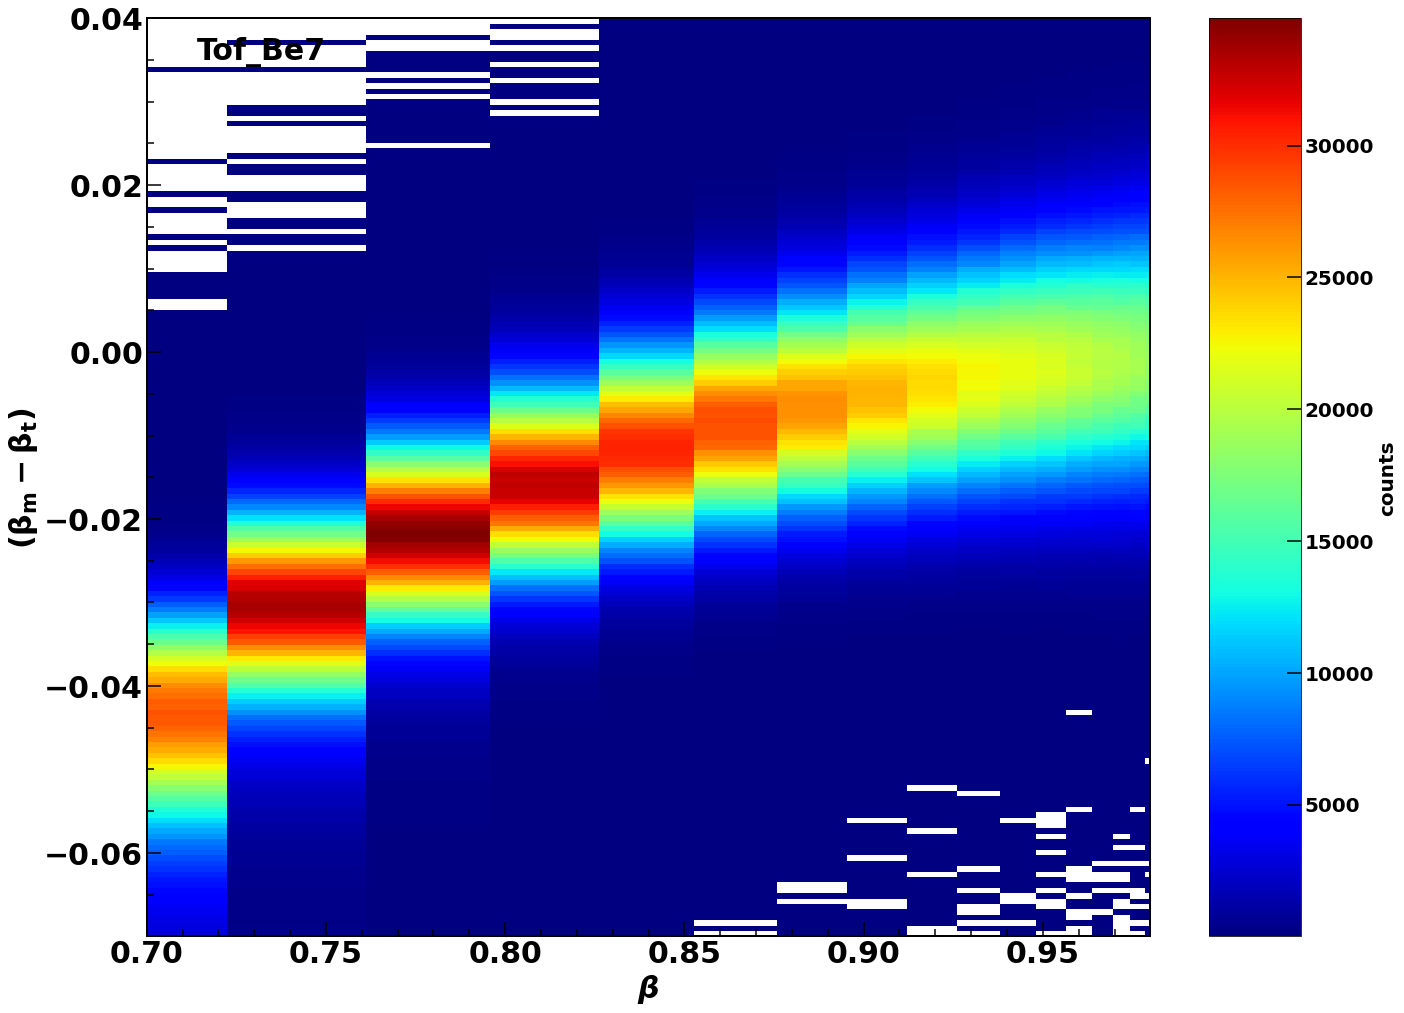

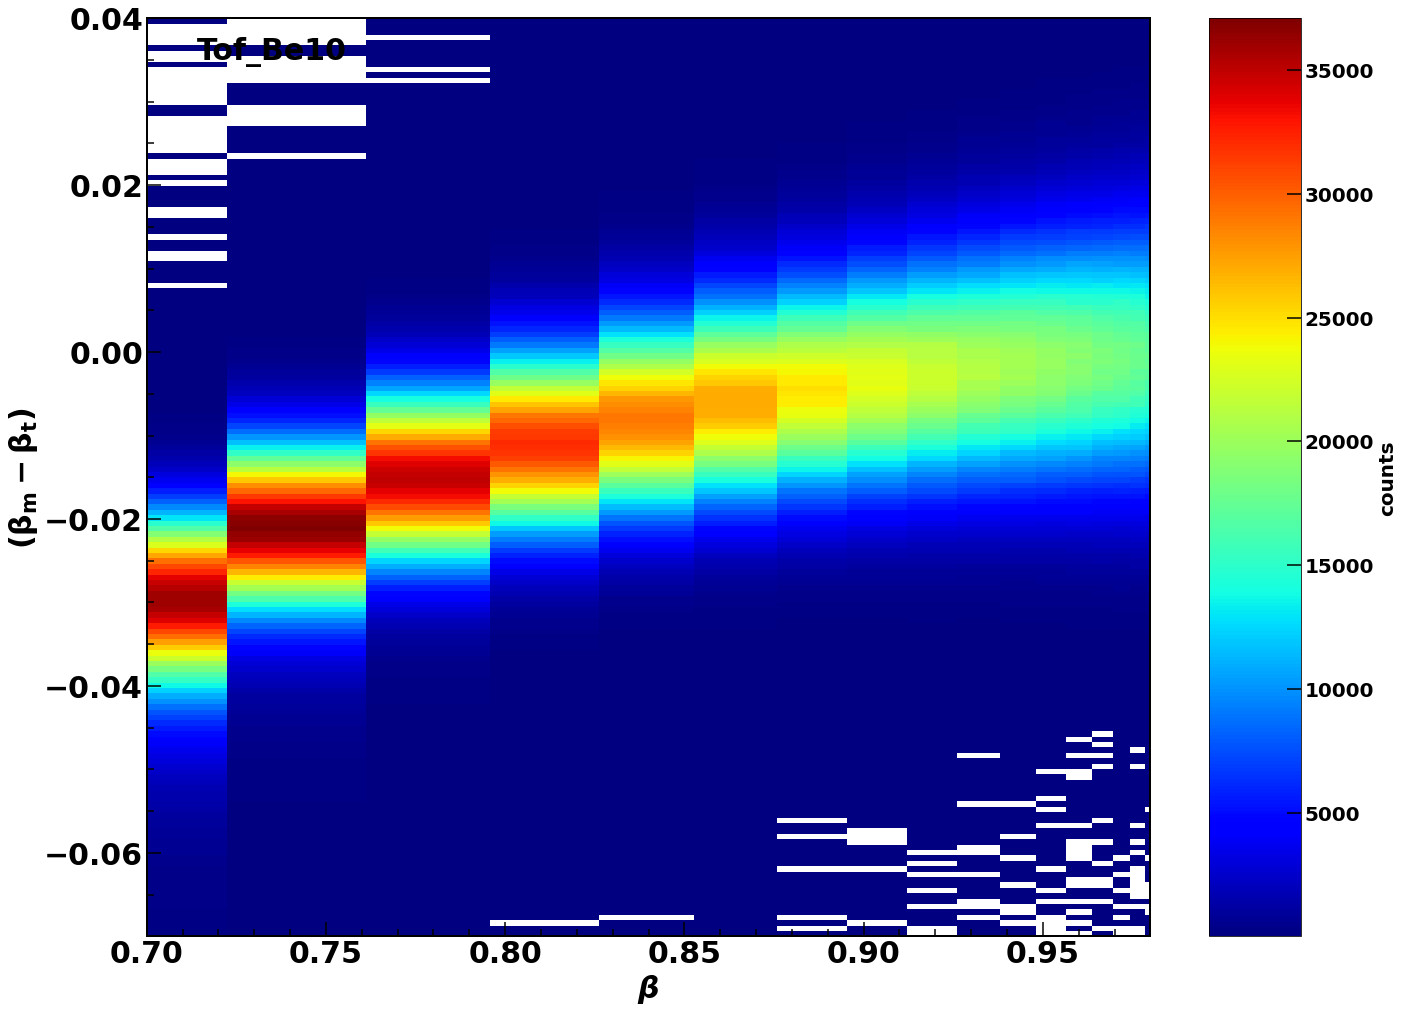

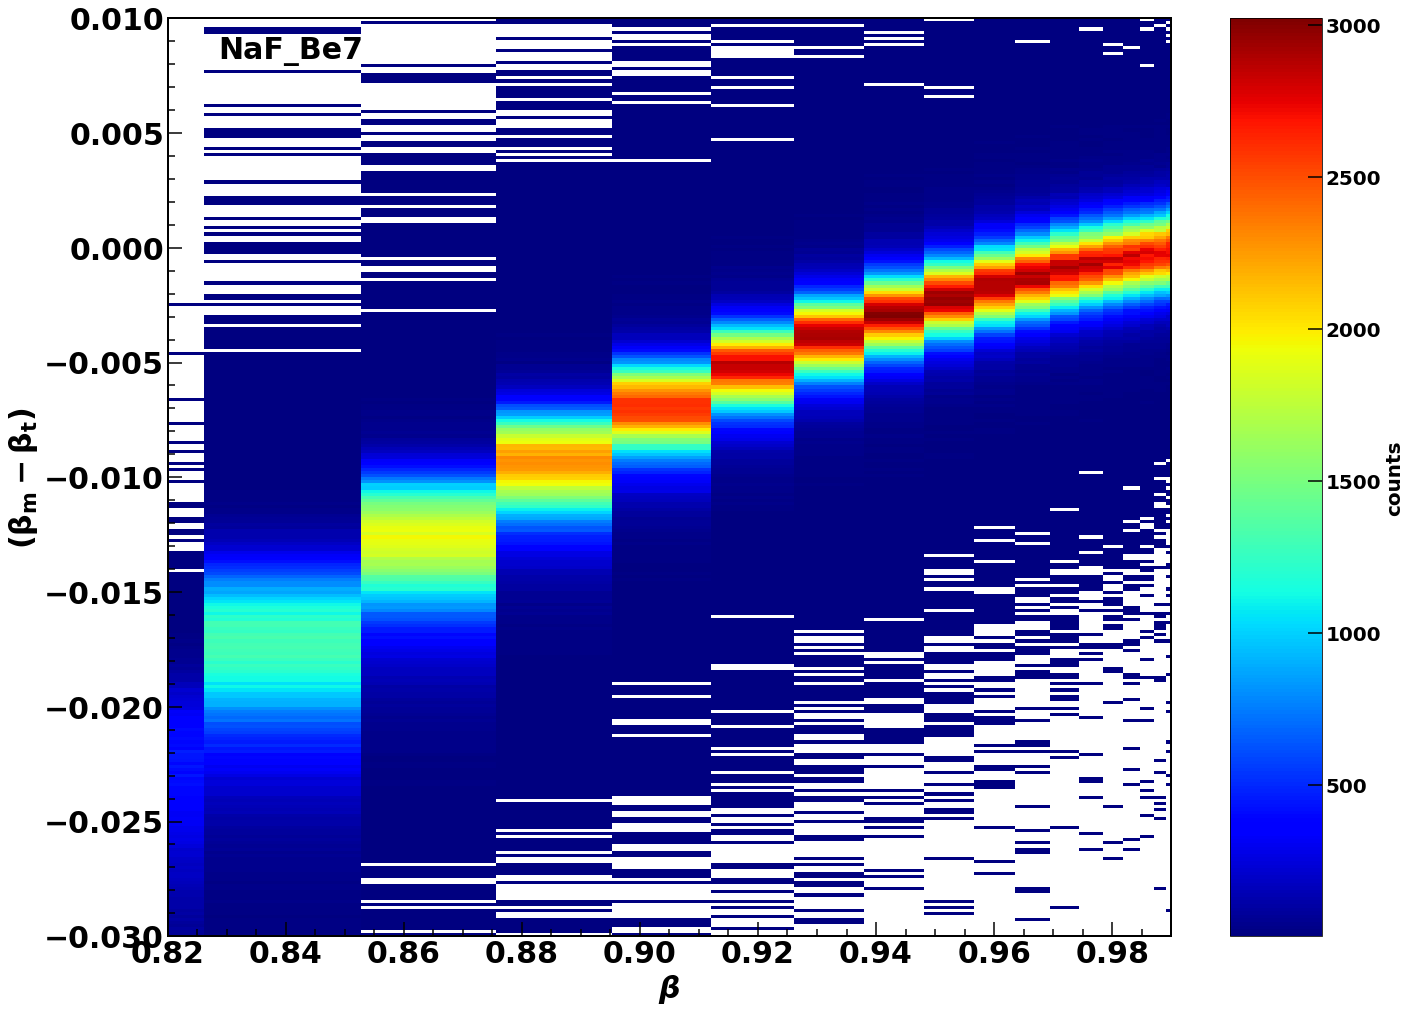

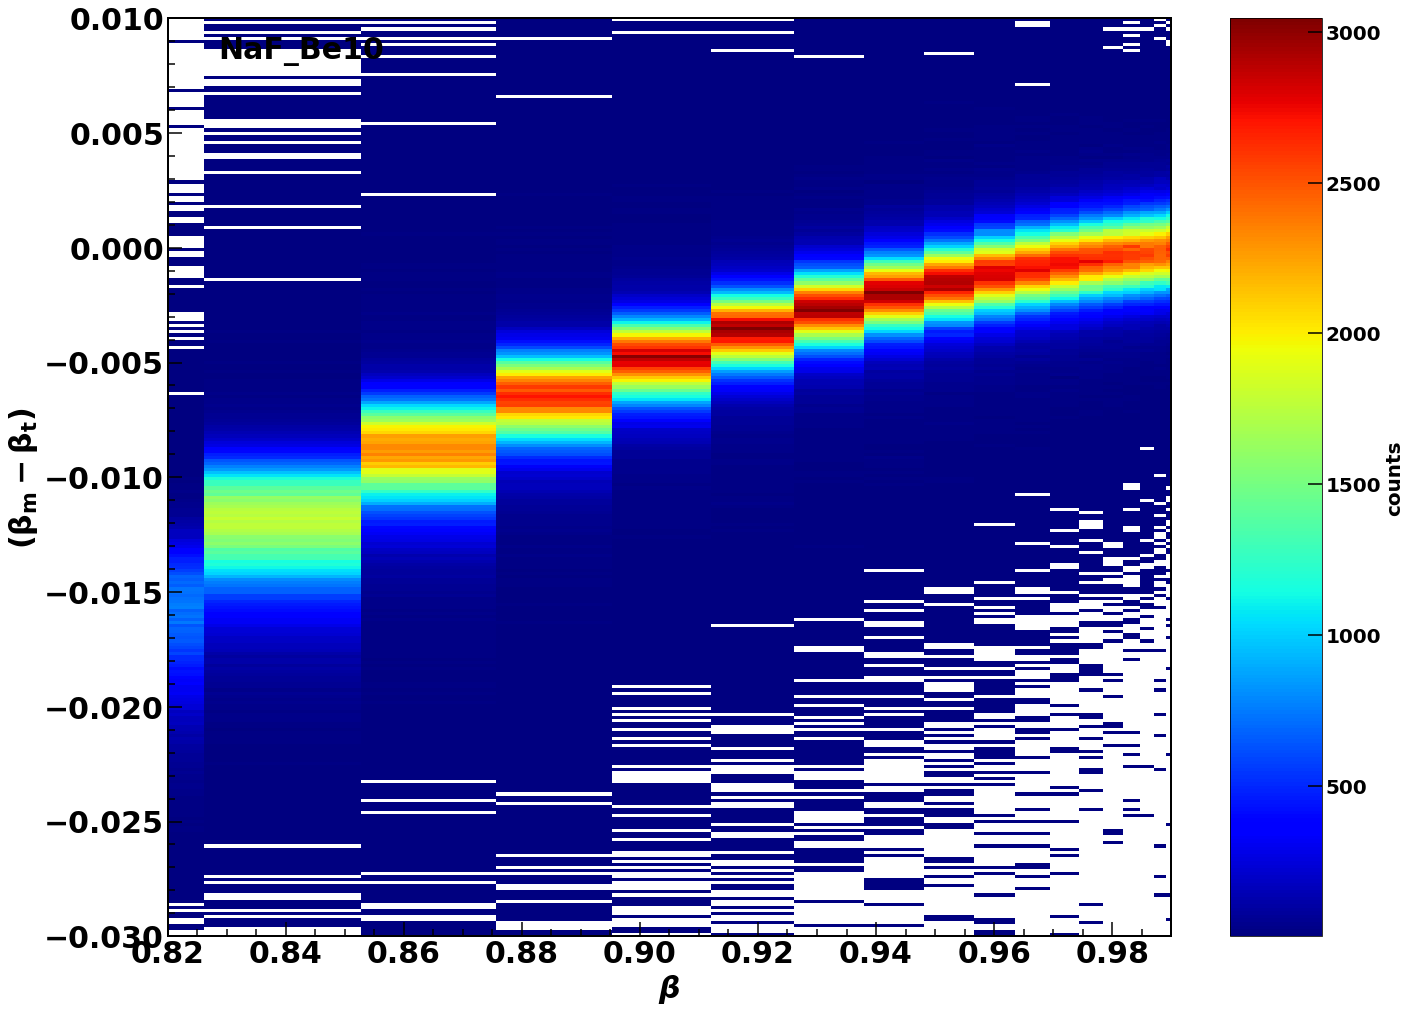

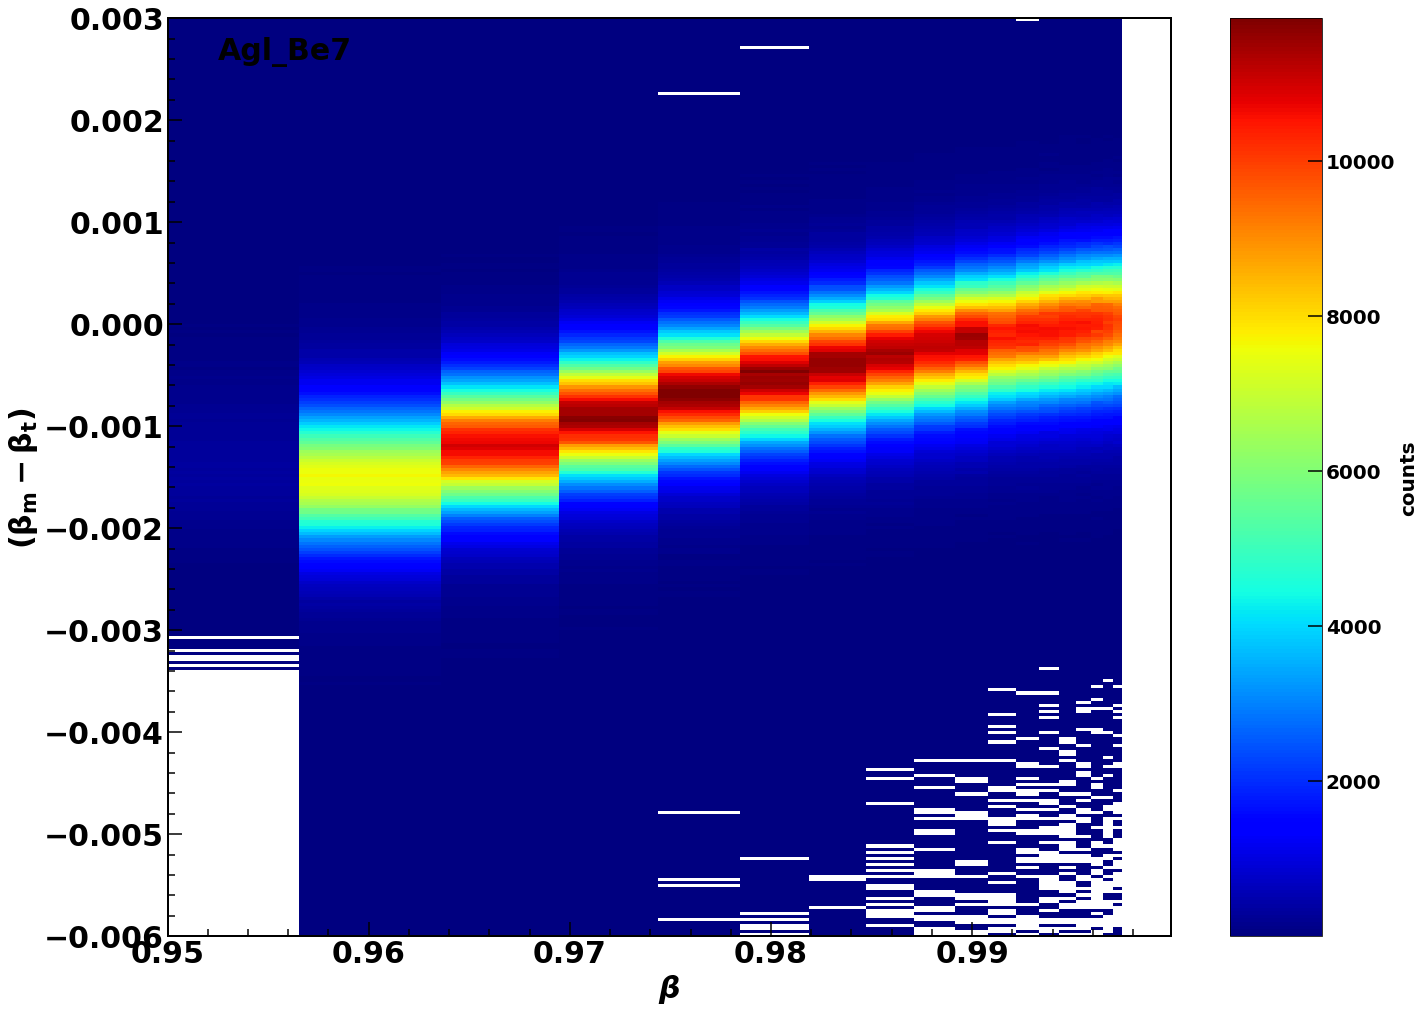

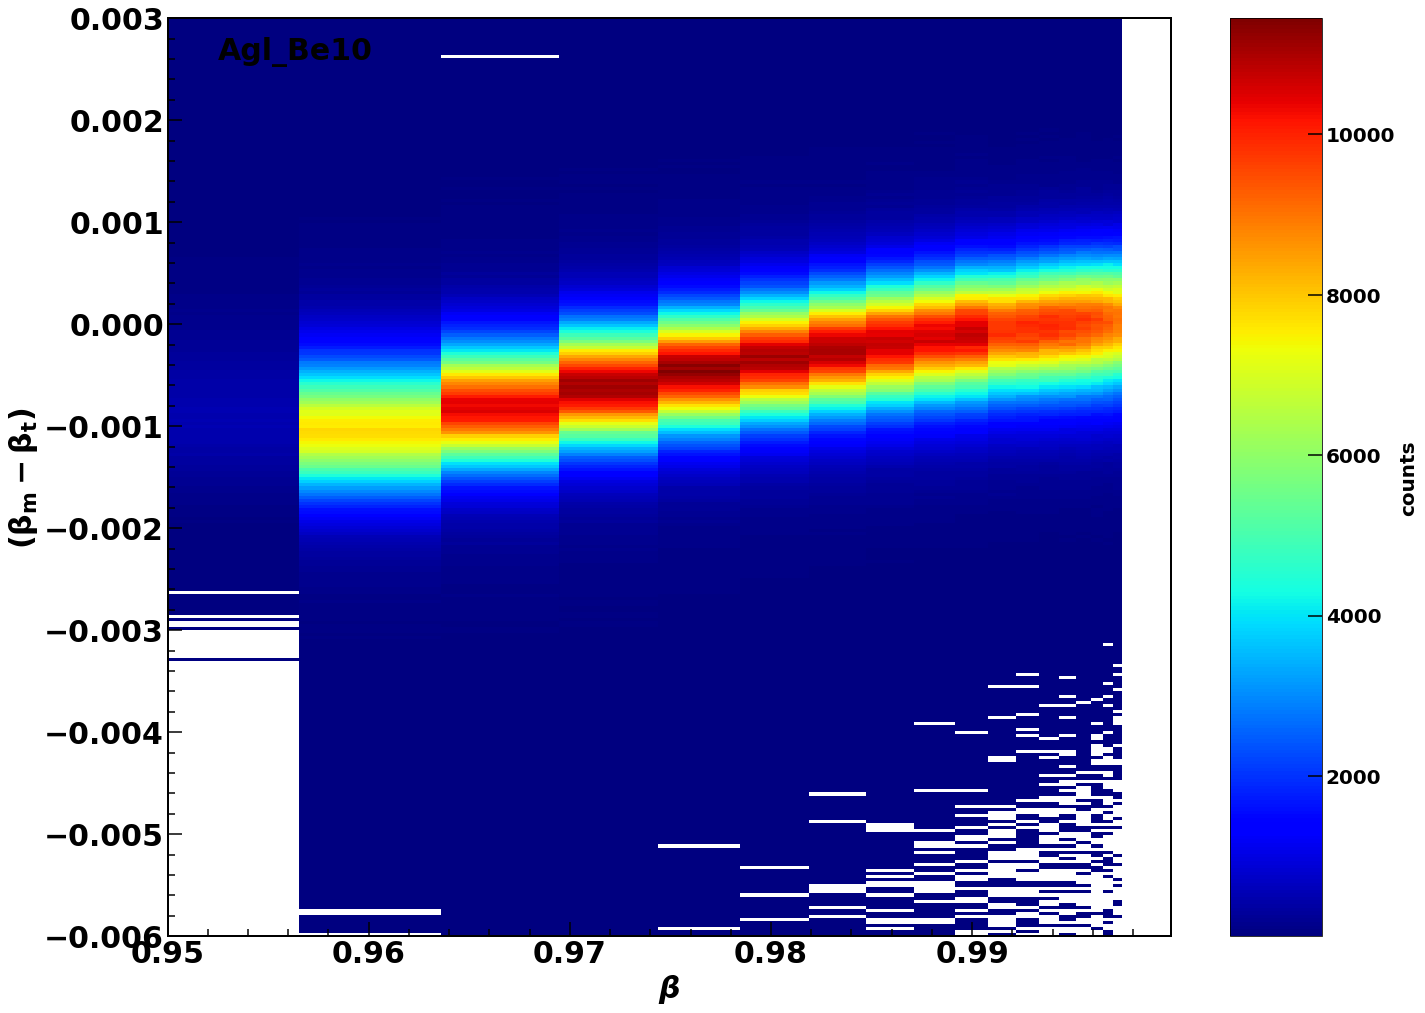

In [45]:
file_beta = '/home/manbing/Documents/Data/data_unfold/dfile/Be7MC_beta_resolution_rawrwth_v1.npz'
isotopes = ['Be7', 'Be10']
hist2d = {dec: {} for dec in detectors}
gammalim = {'Tof':[1.6, 5.0], "NaF":[2.0, 10.0], "Agl":[3.3, 15.0]}
beta_range = {"Tof": [0.7, 0.98], "NaF": [0.82, 0.99], "Agl": [0.95, 0.9999]} 
with np.load(file_beta) as npzfile:
    for dec in detectors:
        for iso in isotopes:
            hist2d[dec][iso] = WeightedHistogram.from_file(npzfile, f"hist2d_beta_residual_{dec}_{iso}")  
            fig = plt.figure(figsize=(20, 15))
            plot = fig.subplots(1, 1) 
            plot2dhist(fig, plot, xbinning=hist2d[dec][iso].binnings[0].edges[1:-1],
                       ybinning=hist2d[dec][iso].binnings[1].edges[1:-1],
                       counts=hist2d[dec][iso].values[1:-1, 1:-1], 
                       xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                       setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=False)  
            plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
            plot.set_xlabel(r"$\beta$", fontsize=30)                                                                                                                                                     
            plot.set_ylabel(r'$\mathrm{(\beta_{m}-\beta_{t})}$', fontsize=30)
            #plot.set_xscale('log')
            plot.set_xlim(beta_range[dec])
            savefig_tofile(fig, plotdir, f"hist2d_{dec}_{iso}", show=True)                                                                                                                 

#for ibin in range(28):
#    hist_ibin_gamma = hist2d['Agl']['Be7'].project(ibin)
#print(hist2d_gamma[dec][iso].binnings[0].edges[1:-1][22])
#fig = plt.figure(figsize=(20, 15))
#plot = fig.subplots(1, 1) 
#plot_histogram_1d(plot, hist_ibin_gamma, style="iss", color="black", label="data", scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False)


Now I have the fit the resolutions and get the parameters. (reso_prob)
The following steps are :
1. write the function for the calculating the rate with (flux * acc * reso_prob)

In [22]:
### 
# x = beta_rec - beta_true 
from scipy import integrate
parnames = ['mean', 'sigma', 'sigma_ratio', 'asy_factor', 'fraccore']

def prob_resolution(x, mean, sigma, sigma_ratio, asy_factor, fraccore):                                                                                                                                                                      
    coregaus = gaussian(x, mean, sigma)                                                                                                                                                                                                           
    asygaus = asy_gaussian_1d(x, mean,  sigma_ratio * sigma, asy_factor)                                                                                                                                                                          
    pdf = (fraccore * coregaus + (1 - fraccore) * asygaus)                                                                                                                                                                                 
    return pdf 

#when transfer flux from ekin to beta, need the term dE/dBeta
def dEdbeta(beta):
    return mass_nucleon_gev * beta * (1-beta**2)**(-3/2)

def rate_func(b_true, b_rec, phi, c, rigidity_scale, gamma, spline_acc, df_probpars):
    flux = power_law(calc_ekin_from_beta(b_true), phi, c, rigidity_scale, gamma) * dEdbeta(b_true)
    fluxTimeAcc = flux * spline_acc(np.log(calc_ekin_from_beta(b_true))) 
    prob_par = dict()
    for par in parnames:
        prob_par[par] = np.poly1d(df_probpars[par])(np.log(b_true))
    #event_rate = fluxTimeAcc * prob_resolution(b_rec - b_true, prob_par['mean'], prob_par['sigma'], prob_par['sigma_ratio'],prob_par['fraccore'],prob_par['asy_factor'] )
    event_rate = fluxTimeAcc * prob_resolution(1/b_rec - 1/b_true, **prob_par) * (1/b_rec)**2
    return event_rate
    
    

integrate the rate function to get the prediction_rate in each beta bin 

In [46]:
def get_predict_rate(xbeta_binning, beta_range, flux_pars, spline_acc, resoprobpars):
    binrange = xbeta_binning.get_indices(beta_range) 
    xvalue_beta = xbeta_binning.bin_centers[binrange[0]: binrange[1]] 
    predict_rate = np.zeros_like(xvalue_beta)
    predict_rate_err = np.zeros_like(xvalue_beta)
    #print(xbeta_binning.edges)
    #print(xvalue_beta)
    prob_par = dict()
    mu = np.poly1d(resoprobpars['mean'])(np.log(xvalue_beta))
    sig = np.poly1d(resoprobpars['sigma'])(np.log(xvalue_beta))
    #print('mu:', mu)
    #print('sigma:', sig)
    
    for ip, ibin in enumerate(range(binrange[0], binrange[1])): 
        #print(ibin)
        #print('min:', min(ibin+3, len(xbeta_binning.edges)-2))
        ibeta = xbeta_binning.bin_centers[ibin]
        #print(ibeta)
        beta_true_intmin = xbeta_binning.edges[ibin]  + mu[ip] - 4* sig[ip] 
        beta_true_intmax = xbeta_binning.edges[ibin+1] + mu[ip] + 4* sig[ip] 
        #print(ibeta)
        #print('A:', beta_true_intmin,beta_true_intmax)
        #print('B:', xbeta_binning.edges[max(1, ibin-2)], xbeta_binning.edges[min(ibin+3, len(xbeta_binning.edges)-2)])
        predict_rate[ip], predict_rate_err[ip] = integrate.nquad(rate_func, [[xbeta_binning.edges[max(1, ibin-2)], xbeta_binning.edges[min(ibin+3, len(xbeta_binning.edges)-2)]],[xbeta_binning.edges[ibin],xbeta_binning.edges[ibin+1]]], args=list(flux_pars)+[spline_acc, resoprobpars], opts=dict(epsrel=1e-3))
        #predict_rate[ip], predict_rate_err[ip] = integrate.nquad(rate_func, [[beta_true_intmin, beta_true_intmax],[xbeta_binning.edges[ibin],xbeta_binning.edges[ibin+1]]], args=list(flux_pars)+[spline_acc, resoprobpars], opts=dict(epsrel=1e-3))
         
    return predict_rate


Minimization 

In [47]:
flux_parnames = ['phi', 'c', 'rigidity_scale', 'gamma']
class func_LeastSquares:
    def __init__(self, graph_measure_rate, xbeta_binning, beta_range, spline_acc, resoprobpars):                                                                                                                                                                                                       
        self.func_code = make_func_code([par for par in flux_parnames])  
        self.ygraph = graph_measure_rate
        self.yvector = graph_measure_rate.yvalues    
        self.yvector_err = graph_measure_rate.yerrs
        self.xbeta_binning = xbeta_binning
        self.beta_range = beta_range
        self.spline_acc = spline_acc
        self.resoprobpars = resoprobpars
        
    def __call__(self, *par):
        flux_pars = par
        predict_rate = get_predict_rate(self.xbeta_binning, self.beta_range, flux_pars, self.spline_acc, self.resoprobpars)
        chis = np.sum(((predict_rate - self.yvector)/self.yvector_err)**2)
        print(chis)
        return chis



In [48]:
def run_unfold_minimization(decname, isoname, graph_measured_rate, xbeta_binning, beta_range, spline_acc, guess, resoprobpars):
    lsq = func_LeastSquares(graph_measured_rate, xbeta_binning, beta_range, spline_acc, resoprobpars)                                                                                                                                                                          
    minuit = Minuit(lsq, **guess)                                                                                                                                                                                                             
    minuit.errordef = 1.0                                                                                                                                                                                                                     
    minuit.migrad()                                                                                                                                                                                                                           
    minuit.hesse()    
    print(minuit)
    print(minuit.values)
    mvalues = minuit.values
    merrs = minuit.errors
    return mvalues, merrs

def true_rate_func(b_true, phi, c, rigidity_scale, gamma, spline_acc):
    flux = power_law(calc_ekin_from_beta(b_true), phi, c, rigidity_scale, gamma) * dEdbeta(b_true)
    fluxTimeAcc = flux * spline_acc(np.log(calc_ekin_from_beta(b_true))) 
    event_rate = fluxTimeAcc 
    return event_rate

#get the true unfolded rate with the flux_pars got from the minimization
def get_unfold_rate(xbeta_binning, beta_range, flux_pars, spline_acc):
    binrange = xbeta_binning.get_indices(beta_range) 
    xvalue_beta = xbeta_binning.bin_centers[binrange[0]: binrange[1]] 
    unfold_rate = np.zeros_like(xvalue_beta)
    unfold_rate_err = np.zeros_like(xvalue_beta)
    for ip, ibin in enumerate(range(binrange[0], binrange[1])): 
        unfold_rate[ip], unfold_rate_err[ip] = integrate.quad(true_rate_func, xbeta_binning.edges[ibin], xbeta_binning.edges[ibin+1], args=tuple(list(flux_pars)+[spline_acc]), epsrel=1e-3)  
    return unfold_rate
    

In [56]:
RANGE_EKIN_PLUSONE = {"Tof": [0.6, 1.2], "NaF": [1.3, 4.2], "Agl": [3.8, 13]}
RANGE_EKIN = {'Tof': [0.6, 1.1], 'NaF':[1.3, 4.0], 'Agl': [4.0,11]}
RANGE_BETA = {dec: calc_beta_from_ekin(np.array(RANGE_EKIN_PLUSONE[dec])) for dec in detectors}
#guess_flux_init = {'phi': 0.91, 'c': 7.89e-3, 'rigidity_scale': 7.89e-3, 'gamma': -3.070}
#guess_flux_init = {'phi': 0.6484788986052318, 'c': 0.007459063428695519, 'rigidity_scale': 7.013846850536838, 'gamma': -2.7565763250621}
#phi=0.278800797922473 c=0.006286432544825294 rigidity_scale=6.6331729117951825 gamma=-2.706994460316708>
guess_iter1 = {'Tof': {'phi':0.4316246, 'c':0.008258085, 'rigidity_scale':6.896825, 'gamma': -2.2884089690210385}}
guess_flux_init = {'phi': 0.8166727377324892, 'c': 0.007654295615096592, 'rigidity_scale': 7.081727356698899, 'gamma':-2.9932453444774056}
#print(guess)
#prepare the measured_rate and guess for minimization
datadir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold'
def run_forward_unfold(decname, isotope, graph_measured_rate, xbeta_binning, spline_acc, guess, resoprobpars):
    graph_measured_rate = slice_graph_by_value(graph_measured_rate, RANGE_EKIN[dec])
    print(graph_measured_rate)
    print(len(graph_measured_rate.xvalues))
    binrange_index = xbeta_binning.get_indices(RANGE_BETA[decname]) 
    print('######################################')
    print(f'unfolding for {decname}, {isotope}:')
    print('guess:', guess)
    print('Beta binning:', xbeta_binning.edges)
    print('Beta binning in Ekin:', calc_ekin_from_beta(xbeta_binning.edges))
    print('Beta range:', RANGE_BETA[decname])
    print('number of bins:', binrange_index[1] - binrange_index[0])
    print('bin_centers:', xbeta_binning.bin_centers[binrange_index[0]: binrange_index[1]])
    print('bin_centers_ekin:', calc_ekin_from_beta(xbeta_binning.bin_centers[binrange_index[0]: binrange_index[1]]))      
    mvalues, merr = run_unfold_minimization(decname, isotope, graph_measured_rate, xbeta_binning, RANGE_BETA[decname], spline_acc, guess, resoprobpars)
    print('#end minimization#')
    unfold_rate = get_unfold_rate(xbeta_binning, RANGE_BETA[decname], mvalues, spline_acc)
    predict_rate = get_predict_rate(xbeta_binning, RANGE_BETA[decname], mvalues, spline_acc, resoprobpars)
    ratio_raw_to_unfold = predict_rate/unfold_rate
    df_results = {'flux_pars':mvalues,
                'flux_pars_err': merr,
                'unfold_rate':unfold_rate,
                'predict_rate': predict_rate,
                'ratio_raw_to_unfold': ratio_raw_to_unfold}  
    np.savez(os.path.join(datadir, f'unfold_results_{decname}{isotope}_v10_invbeta.npz'), **df_results)
    return df_results

        

In [57]:
mass_nucleon_gev = 0.9314941 #in GeV 
#read the resolution fit parameters
df_probbeta_pars = {dec: {} for dec in detectors}
for dec in detectors:
    for iso in ISOTOPES[nuclei]:
        df_probbeta_pars[dec][iso] = np.load(f'/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/beta/{dec}{iso}_polypar_inversebetav2.npz')

            
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
xbeta_binning = Binning(calc_beta_from_ekin(xbinning_energy()))     
print(xbeta_binning.edges)
for iso in ISOTOPES[nuclei]:
    mu = np.poly1d(df_probbeta_pars['Tof'][iso]['mean'])(np.log(xbeta_binning.bin_centers[1:-1]))
    
    graph_mu = MGraph(xbeta_binning.bin_centers[1:-1], mu, np.zeros_like(mu))
    #print(graph_mu)
    #print(iso, mu)
    sig = np.poly1d(df_probbeta_pars['Tof'][iso]['sigma'])(np.log(xbeta_binning.bin_centers[1:-1]))
    
    

[      -inf 0.67941717 0.72381066 0.76229212 0.79686118 0.82723655
 0.85350287 0.87664096 0.89604088 0.91266322 0.9267068  0.93848091
 0.94848055 0.95688253 0.9638856  0.9696962  0.97457228 0.9786407
 0.98202022 0.98485634 0.98722439 0.98919726 0.99089904 0.99222986
 0.99338328 0.99437206 0.99521296 0.99592431 0.99652407 0.99702901
 0.99745389 0.99794337 0.99824543 0.9984855         inf]


In [71]:
dec = 'Tof'
isoes = ['Be7']
#guessP = {'phi': 8.058040582914916, 'c': 0.00023983, 'rigidity_scale': 12.1958, 'gamma':-29.4}
#be9iter1 = <ValueView phi=0.2056395034790969 c=0.01270889909482568 rigidity_scale=5.980622787389986 gamma=-1.5005995937947707>
#be10iter1 = <ValueView phi=4.879867866834633 c=0.00029520203652662054 rigidity_scale=8.805735035490116 gamma=-18.98824802252532>

def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
xbeta_binning = Binning(calc_beta_from_ekin(xbinning_energy()))

unfold_Tof = dict()
for iso in isoes:
    unfold_Tof[iso] = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], isoflux_param_dict[iso], df_probbeta_pars[dec][iso])


xvalues			yvalues			yerrs
0.5589999999999999			0.0015002883874120855			1.3296782522412246e-05
0.66835			0.0015645748765845133			1.138093148969711e-05
0.79125			0.0015515893148638556			1.0546965440149163e-05
0.9302999999999999			0.001561412553095477			9.55414922426596e-06
1.08555			0.001458760540250564			8.819688315426247e-06

5
######################################
unfolding for Tof, Be7:
guess: {'phi': 0.6481041791251355, 'c': 0.009103914025464756, 'rigidity_scale': 6.300087590118193, 'gamma': -2.793550533725551}
Beta binning: [      -inf 0.67941717 0.72381066 0.76229212 0.79686118 0.82723655
 0.85350287 0.87664096 0.89604088 0.91266322 0.9267068  0.93848091
 0.94848055 0.95688253 0.9638856  0.9696962  0.97457228 0.9786407
 0.98202022 0.98485634 0.98722439 0.98919726 0.99089904 0.99222986
 0.99338328 0.99437206 0.99521296 0.99592431 0.99652407 0.99702901
 0.99745389 0.99794337 0.99824543 0.9984855         inf]
Beta binning in Ekin: [ 0.      0.338   0.4185  0.5077  0.6103  0.7264  0

KeyboardInterrupt: 

In [ ]:
from tools.graphs import scale_graph
dec = 'Tof'
iso = 'Be9'
unfold_results1 = np.load(f'/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_{dec}Be7_v9.npz')
unfold_results2 = np.load(f'/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_{dec}{iso}_v10_invbeta.npz')

graph_unfold_factor1 = MGraph(graph_measured_rate[dec][iso].xvalues, 1/unfold_results1['ratio_raw_to_unfold'], np.zeros_like(unfold_results1['ratio_raw_to_unfold']))  
print(graph_measured_rate[dec][iso])

graph_measuredrate = slice_graph_by_value(graph_measured_rate[dec][iso], RANGE_EKIN[dec])
graph_unfold_factor2 = MGraph(graph_measuredrate.xvalues, 1/unfold_results2['ratio_raw_to_unfold'], np.zeros_like(unfold_results2['ratio_raw_to_unfold']))       

fig, ax1 = plt.subplots(figsize=(26, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95)
ax1.set_ylim([0.9, 1.3])

plot_graph(fig, ax1, graph_unfold_factor1, color='green',  style="EP", xlog=True, ylog=False, scale=None, markersize=22) 
plot_graph(fig, ax1, graph_unfold_factor2, color='black',  style="EP", xlog=True, ylog=False, scale=None, markersize=22)          
        
compare_factor = np.array([1.10415405, 1.11743185, 1.11979867, 1.11092794, 1.10511991,
       1.09820484, 1.09441089, 1.08260727, 1.0732978 , 1.07024319,
       1.06461786, 1.05648085, 1.04974455, 1.04560352, 1.04344912,
       1.04213655, 1.03396483, 1.03728443, 1.03752972, 1.03607738,
       1.03368557, 1.03075394, 1.02806917, 1.02610837, 1.0254245 ,
       1.02470803, 1.02454688, 1.02561412, 1.02929802])

ax1.plot(get_bin_center(fbinning_energy()), compare_factor, '-', label='JH Be7')
ax1.legend()
ax1.set_ylabel('Unfolded/Raw')
ax1.set_xlabel('Ekin/n(GeV/n)')
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
savefig_tofile(fig, plotdir, 'unfolding_factor', 1)



In [ ]:
dec = 'Tof'
isoes = ['Be7', 'Be9', 'Be10']
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
xbeta_binning = Binning(calc_beta_from_ekin(xbinning_energy()))

unfold_Tof = dict()
for iso in isoes:
    unfold_Tof[iso] = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], isoflux_param_dict[iso], df_probbeta_pars[dec][iso])

In [31]:
dec = 'Agl'
isoes = ['Be10']
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
xbeta_binning = Binning(calc_beta_from_ekin(xbinning_energy()))
unfold_Agl = dict()

for iso  in isoes:
    unfold_Agl[iso] = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], isoflux_param_dict[iso], df_probbeta_pars[dec][iso])


xvalues			yvalues			yerrs
3.8012500000000005			3.403982097448195e-05			1.4701720195562541e-06
4.2221			2.8308964736812752e-05			1.3914855470553779e-06
4.67795			2.6109933920030307e-05			1.288814306472851e-06
5.16875			2.3935841137290025e-05			1.1934390399612726e-06
5.70575			2.0320439287823265e-05			1.1065814300973324e-06
6.27195			1.535583151317531e-05			9.895153549223683e-07
6.8673			1.375492236797282e-05			9.335518982445684e-07
7.5200499999999995			1.37762818792638e-05			8.710334463243077e-07
8.2303			1.2184343159094442e-05			8.131184936299684e-07
8.99805			1.0124539527697351e-05			7.687592694390212e-07
9.82325			8.47591701976718e-06			7.318996905344692e-07
10.7059			6.6991326555682815e-06			7.020505406322094e-07
11.64595			5.3967184347367544e-06			6.824500620788048e-07

13
######################################
unfolding for Agl, Be10:
guess: {'phi': 0.4491901026056573, 'c': 0.0016297137124571066, 'rigidity_scale': 5.163415443072013, 'gamma': -2.4342271563770317}
Beta binning: [  

In [51]:
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
dec = 'NaF'
iso = 'Be10'
xbeta_binning = Binning(calc_beta_from_ekin(xbinning_energy()))
unfold_NaFbe7 = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], guess_flux_init, df_probpars[dec])

NameError: name 'df_probpars' is not defined

In [75]:
dec = 'Agl'
isoes = ['Be7', 'Be9', 'Be10']
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
xbeta_binning = Binning(calc_beta_from_ekin(xbinning_energy()))
unfold_NaF= dict()
guessinti = {'phi': 1.083734, 'c':0.00733152,  'rigidity_scale': 6.138508100, 'gamma': -3.588975187034548}
print(list(spline_subgraph_acc['NaF'].keys()))
print(list(graph_measured_rate['NaF'].keys()))

print(list(df_probbeta_pars['NaF'].keys()))
for iso  in isoes:
    print(iso)
    unfold_NaF[iso] = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], isoflux_param_dict[iso], df_probbeta_pars[dec][iso])

['Be7', 'Be9', 'Be10']
['Be7', 'Be9', 'Be10']
['Be7', 'Be9', 'Be10']
Be7

xvalues			yvalues			yerrs
3.8012500000000005			0.0002689912861537878			1.6860211741142107e-06
4.2221			0.00023585294202490068			1.3914502941378093e-06
4.67795			0.0002057708143764184			1.2374568558598052e-06
5.16875			0.0001763208040810615			1.1404023648316845e-06
5.70575			0.0001577154492332271			1.0690135848028051e-06
6.27195			0.00012727576935672364			9.392557356493369e-07
6.8673			0.00011310614600897505			8.658817817332091e-07
7.5200499999999995			9.886757974827726e-05			7.739335454946305e-07
8.2303			8.463308055955593e-05			7.093854216864862e-07
8.99805			7.250027929158697e-05			6.606088897565786e-07
9.82325			6.284806864698333e-05			6.360714213172424e-07
10.7059			5.270382012858783e-05			6.300036106242339e-07

12
######################################
unfolding for Agl, Be7:
guess: {'phi': 0.6481041791251355, 'c': 0.009103914025464756, 'rigidity_scale': 6.300087590118193, 'gamma': -2.793550533725551}
Beta b

ValueError: operands could not be broadcast together with shapes (13,) (12,) 


xvalues			yvalues			yerrs
1.08555			8.112839674076364e-05			3.6283558920356757e-06
1.2570999999999999			5.879600628058816e-05			3.1427940369796535e-06
1.44745			5.648122457701587e-05			2.6303481767687733e-06
1.6566			6.0180087487229744e-05			2.3122918624927993e-06
1.8872			5.06083195642545e-05			2.1093231242121113e-06
2.1419			4.333318407711849e-05			1.8758407410605895e-06
2.42075			3.8739333252822266e-05			1.6381171973050922e-06
2.7237			3.2352676719806654e-05			1.4345242195902562e-06
3.0534			3.234285426161449e-05			1.2889641685672843e-06
3.4126000000000003			2.310975199716318e-05			1.1743330479343104e-06
3.8012500000000005			2.3570142816281726e-05			1.0841504399912338e-06



Text(0.5, 0, 'Ekin/n(GeV/n)')

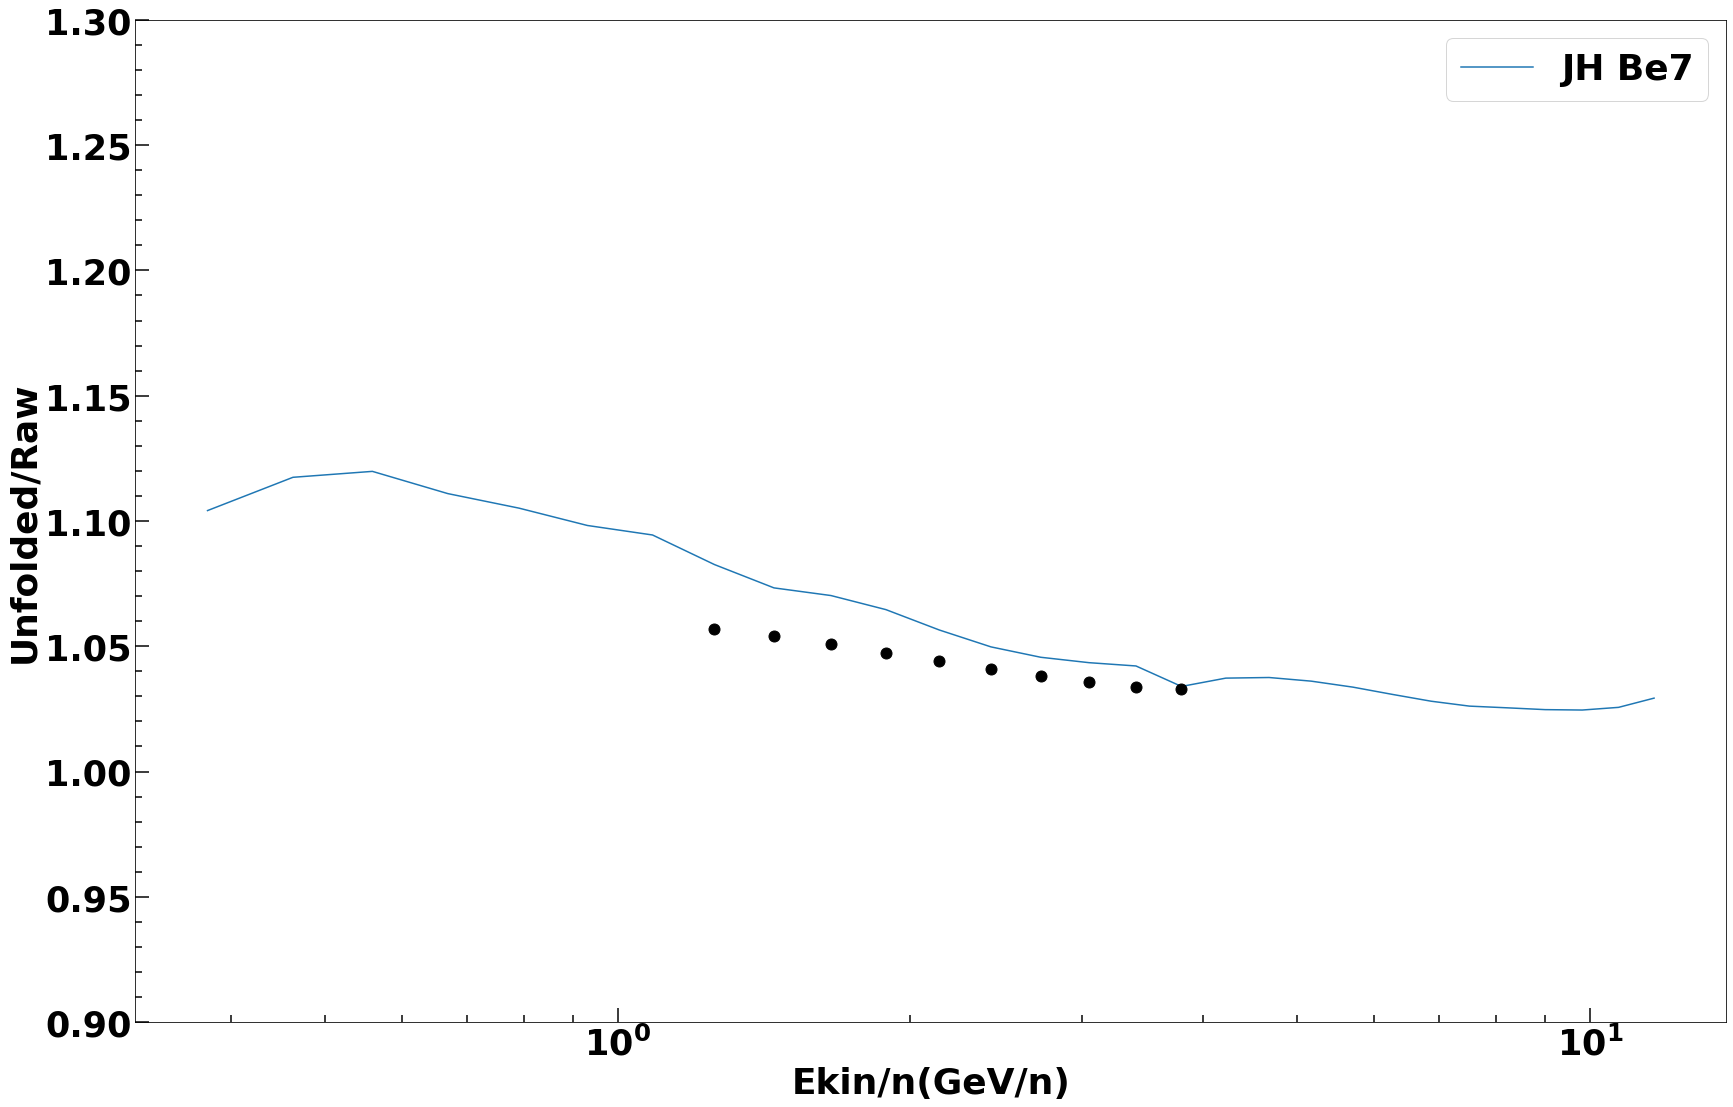

In [73]:
from tools.graphs import scale_graph
dec = 'NaF'
iso = 'Be9'
unfold_results1 = np.load(f'/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_{dec}Be7_v9.npz')
unfold_results2 = np.load(f'/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_{dec}{iso}_v10_invbeta.npz')

graph_unfold_factor1 = MGraph(graph_measured_rate[dec][iso].xvalues, 1/unfold_results1['ratio_raw_to_unfold'], np.zeros_like(unfold_results1['ratio_raw_to_unfold']))  
print(graph_measured_rate[dec][iso])

graph_measuredrate = slice_graph_by_value(graph_measured_rate[dec][iso], RANGE_EKIN[dec])
graph_unfold_factor2 = MGraph(graph_measuredrate.xvalues, 1/unfold_results2['ratio_raw_to_unfold'], np.zeros_like(unfold_results2['ratio_raw_to_unfold']))       

fig, ax1 = plt.subplots(figsize=(26, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95)
ax1.set_ylim([0.9, 1.3])

#plot_graph(fig, ax1, graph_unfold_factor1, color='green',  style="EP", xlog=True, ylog=False, scale=None, markersize=22) 
plot_graph(fig, ax1, graph_unfold_factor2, color='black',  style="EP", xlog=True, ylog=False, scale=None, markersize=22)          
        
compare_factor = np.array([1.10415405, 1.11743185, 1.11979867, 1.11092794, 1.10511991,
       1.09820484, 1.09441089, 1.08260727, 1.0732978 , 1.07024319,
       1.06461786, 1.05648085, 1.04974455, 1.04560352, 1.04344912,
       1.04213655, 1.03396483, 1.03728443, 1.03752972, 1.03607738,
       1.03368557, 1.03075394, 1.02806917, 1.02610837, 1.0254245 ,
       1.02470803, 1.02454688, 1.02561412, 1.02929802])

ax1.plot(get_bin_center(fbinning_energy()), compare_factor, '-', label='JH Be7')
ax1.legend()
ax1.set_ylabel('Unfolded/Raw')
ax1.set_xlabel('Ekin/n(GeV/n)')




In [70]:
from tools.graphs import scale_graph
dec = 'Tof'
isoes = ['Be9', 'Be10']
unfold_results1 = np.load(f'/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_{dec}Be7_v9.npz')
unfold_results2 = dict()
for iso in isoes:
    unfold_results2[iso] = np.load(f'/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_{dec}{iso}_v10_invbeta.npz')

    

graph_unfold_factor1 = MGraph(graph_measured_rate[dec][iso].xvalues, 1/unfold_results1['ratio_raw_to_unfold'], np.zeros_like(unfold_results1['ratio_raw_to_unfold']))  
print(graph_measured_rate[dec][iso])

graph_measuredrate = dict()
graph_unfold_factor2 = dict()
for iso in isoes:
    graph_measuredrate[iso] = slice_graph_by_value(graph_measured_rate[dec][iso], RANGE_EKIN[dec])
    graph_unfold_factor2[iso] = MGraph(graph_measuredrate[iso].xvalues, 1/unfold_results2[iso]['ratio_raw_to_unfold'], np.zeros_like(unfold_results2[iso]['ratio_raw_to_unfold']))       

fig, ax1 = plt.subplots(figsize=(26, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95)
ax1.set_ylim([0.9, 1.3])

#plot_graph(fig, ax1, graph_unfold_factor1, color='green',  style="EP", xlog=True, ylog=False, scale=None, markersize=22) 
for iso in isoes:
    plot_graph(fig, ax1, graph_unfold_factor2[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)          
        
compare_factor = np.array([1.10415405, 1.11743185, 1.11979867, 1.11092794, 1.10511991,
       1.09820484, 1.09441089, 1.08260727, 1.0732978 , 1.07024319,
       1.06461786, 1.05648085, 1.04974455, 1.04560352, 1.04344912,
       1.04213655, 1.03396483, 1.03728443, 1.03752972, 1.03607738,
       1.03368557, 1.03075394, 1.02806917, 1.02610837, 1.0254245 ,
       1.02470803, 1.02454688, 1.02561412, 1.02929802])

ax1.plot(get_bin_center(fbinning_energy()), compare_factor, '-', label='JH Be7')
ax1.legend()
ax1.set_ylabel('Unfolded/Raw')
ax1.set_xlabel('Ekin/n(GeV/n)')




FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_TofBe7_v10_invbeta.npz'

In [ ]:
dec = 'Tof'
iso = 'Be7'
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
xbeta_binning = Binning(calc_beta_from_ekin(xbinning_energy()))
unfold_Tofbe7 = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], guess_flux_init, df_probpars[dec])

In [ ]:
unfold_results_NaFBe7 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_NaFBe7_v4.npz')
print(list(unfold_results_NaFBe7.keys()))

unfold_results_AglBe7 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_AglBe7_v7.npz')
print(list(unfold_results_AglBe7.keys()))

unfold_results_TofBe7 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_TofBe7.npz')
print(list(unfold_results_TofBe7.keys()))

unfold_results_Be7 = {'Tof': unfold_results_TofBe7, 'NaF': unfold_results_NaFBe7, 'Agl':unfold_results_AglBe7}

In [ ]:
graph_unflod_factor_tof = MGraph(graph_measured_rate['Tof']['Be7'].xvalues, 1/unfold_results_TofBe7['ratio_raw_to_unfold'], np.zeros_like(unfold_results_TofBe7['ratio_raw_to_unfold']))
graph_unflod_factor_naf = MGraph(graph_measured_rate['NaF']['Be7'].xvalues, 1/unfold_results_NaFBe7['ratio_raw_to_unfold'], np.zeros_like(unfold_results_NaFBe7['ratio_raw_to_unfold']))
graph_unflod_factor_agl = MGraph(graph_measured_rate['Agl']['Be7'].xvalues, 1/unfold_results_AglBe7['ratio_raw_to_unfold'], np.zeros_like(unfold_results_AglBe7['ratio_raw_to_unfold']))
fig, ax1 = plt.subplots(figsize=(26, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95)
print(graph_unflod_factor_tof)
graph_unflod_factor_tof.yvalues = graph_unflod_factor_tof.yvalues * 1.01
plot_graph(fig, ax1, graph_unflod_factor_tof, color=DETECTOR_COLOR['Tof'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be7 Tof') 
plot_graph(fig, ax1, graph_unflod_factor_naf, color=DETECTOR_COLOR['NaF'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be7 NaF') 
plot_graph(fig, ax1, graph_unflod_factor_agl, color=DETECTOR_COLOR['Agl'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be7 Agl') 
ax1.set_ylim([0.9, 1.3])
compare_factor = np.array([1.10415405, 1.11743185, 1.11979867, 1.11092794, 1.10511991,
       1.09820484, 1.09441089, 1.08260727, 1.0732978 , 1.07024319,
       1.06461786, 1.05648085, 1.04974455, 1.04560352, 1.04344912,
       1.04213655, 1.03396483, 1.03728443, 1.03752972, 1.03607738,
       1.03368557, 1.03075394, 1.02806917, 1.02610837, 1.0254245 ,
       1.02470803, 1.02454688, 1.02561412, 1.02929802])

ax1.plot(get_bin_center(fbinning_energy()), compare_factor, '-', label='JH')
ax1.legend()
ax1.set_ylabel('Unfolded/Raw')
ax1.set_xlabel('Ekin/n(GeV/n)')
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_2009/plots_2009'
savefig_tofile(fig, plotdir, 'unfolding_factor_Be7', 1)

In [19]:
decs = ['Tof', 'NaF', 'Agl']
unfold_results = {dec: {} for dec in decs}
for dec in decs:
    for iso in ISOTOPES[nuclei]:
        unfold_results[dec][iso] = np.load(f'/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_{dec}{iso}_v9.npz')

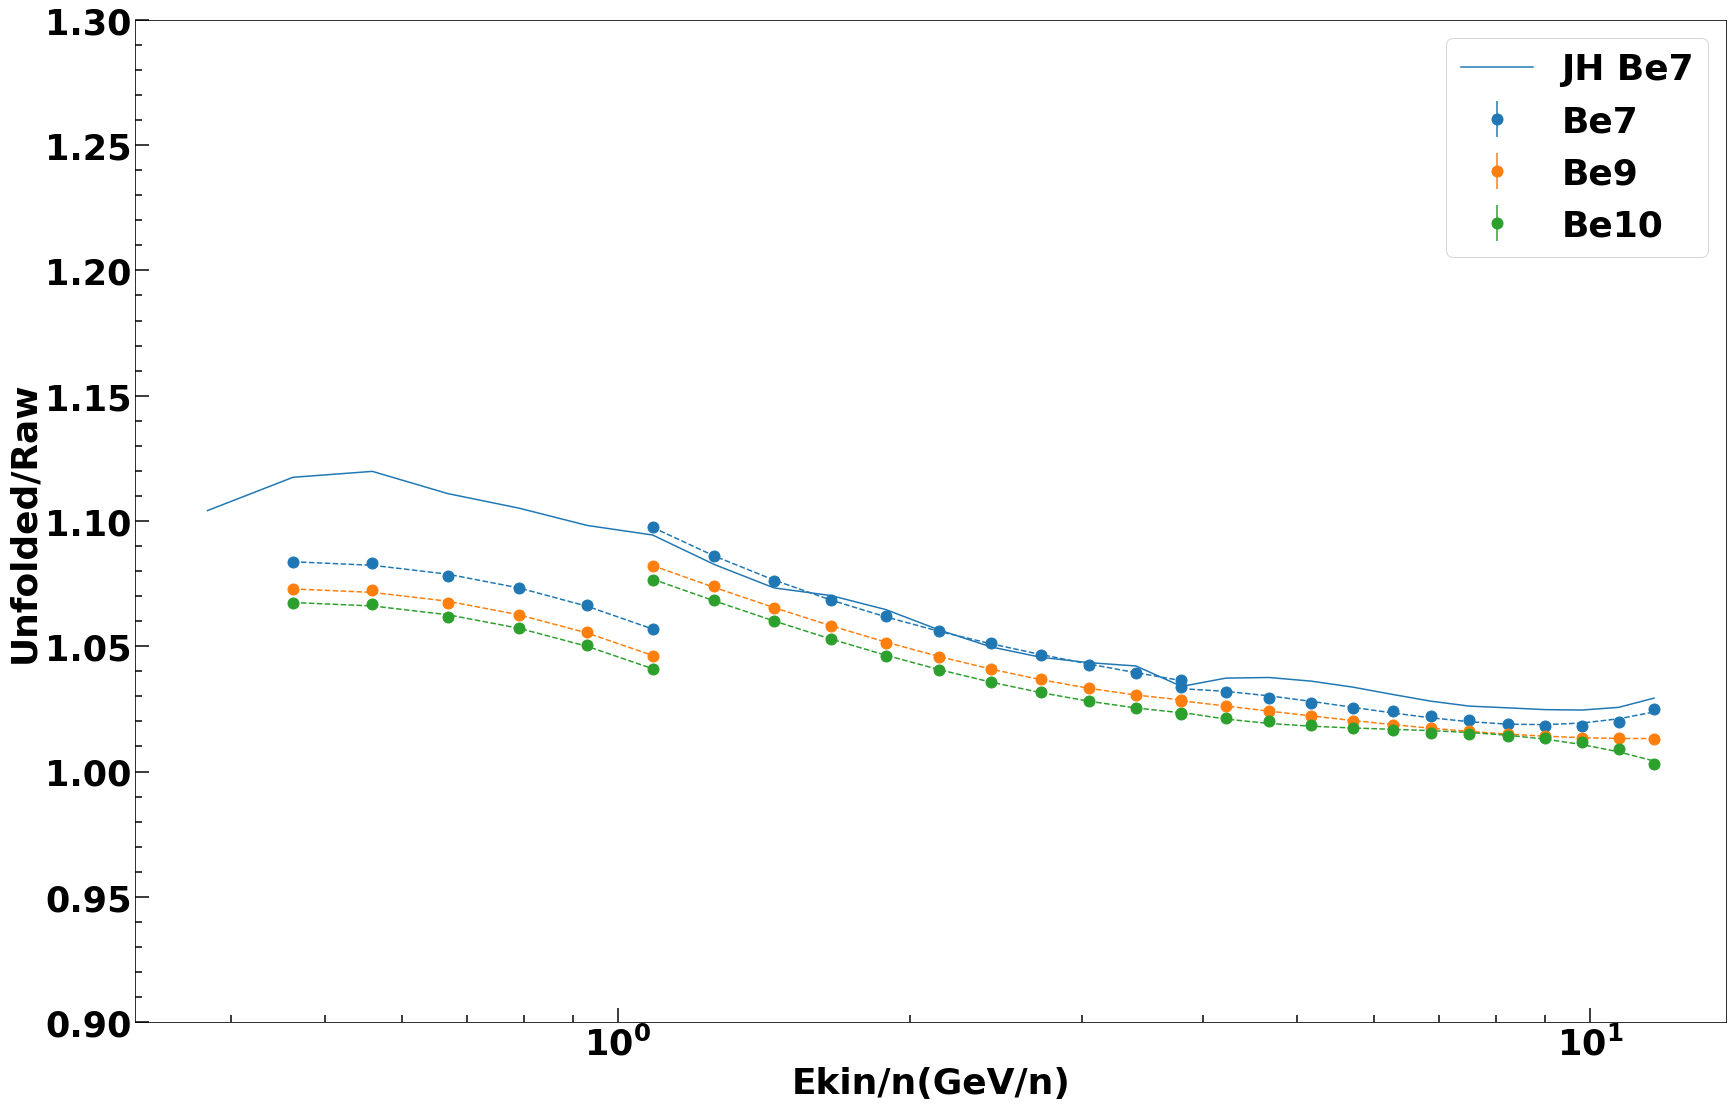

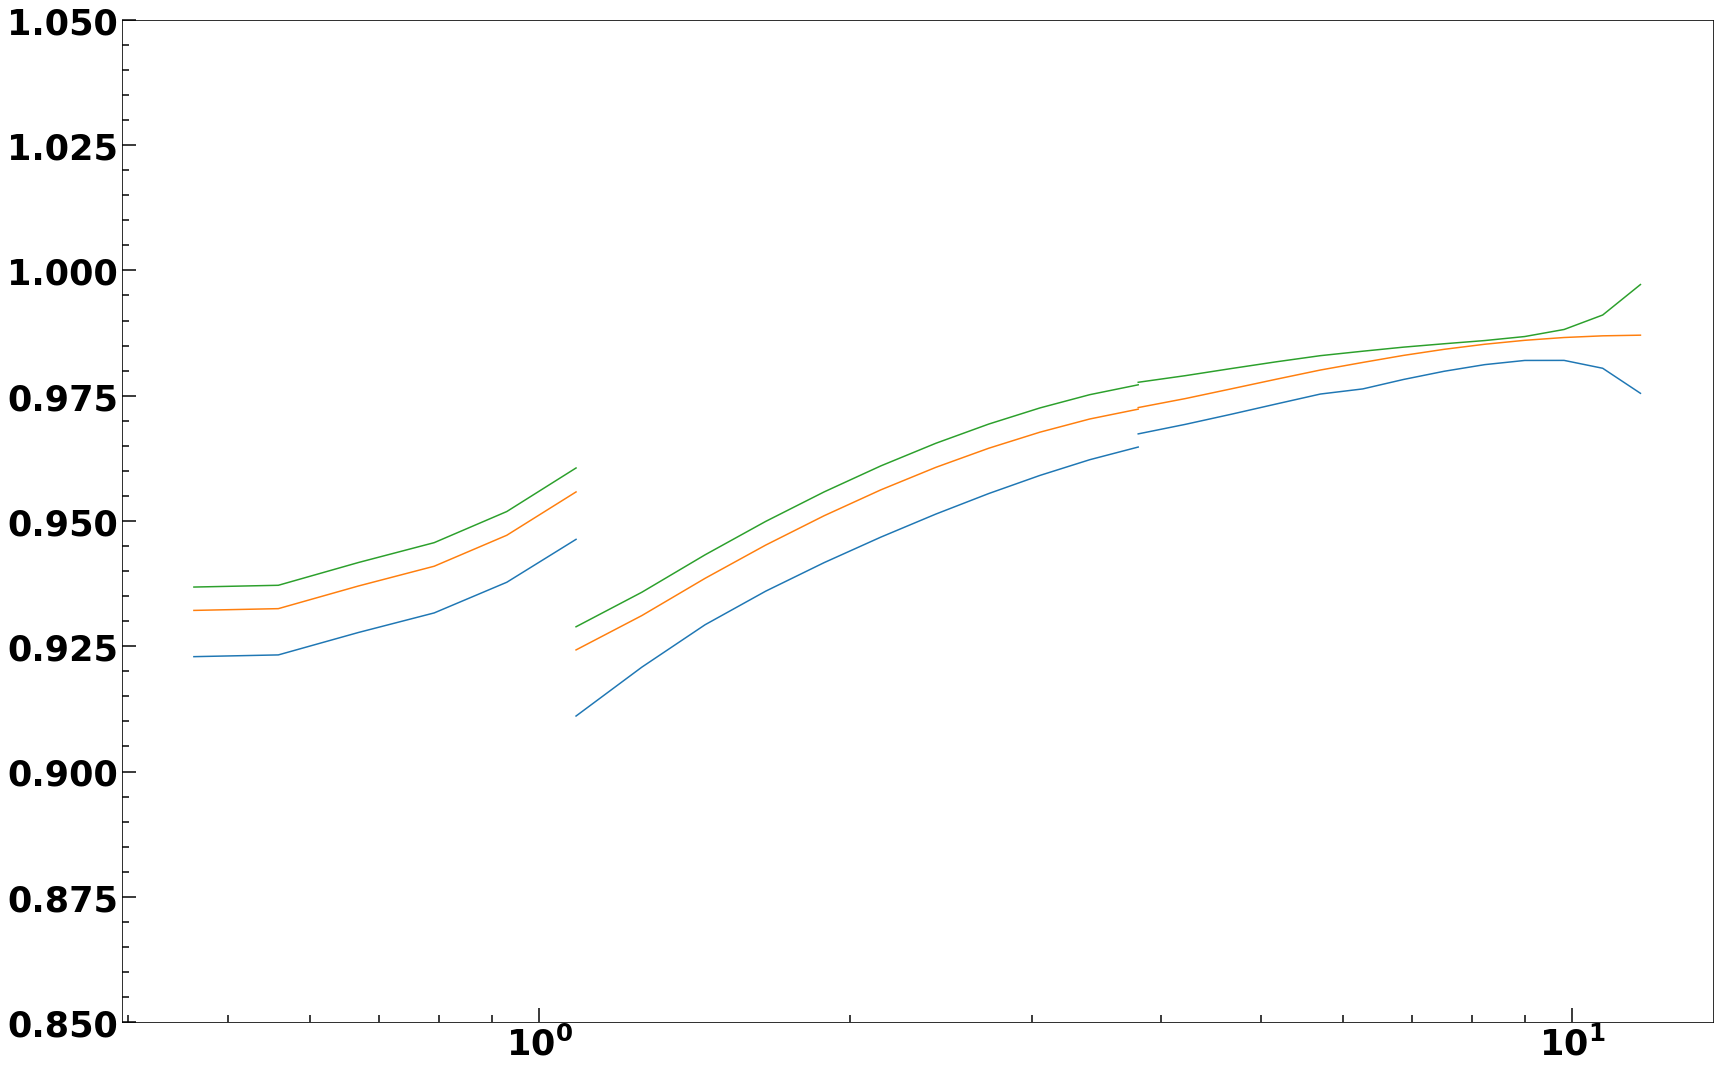

In [33]:
from tools.graphs import scale_graph
detectos = ['Tof', 'NaF', 'Agl']
graph_unfold_factor = {dec: {} for dec in detectors}
spline_unfold_factor = {dec: {} for dec in detectors}
graph_unfold_factor_inverse = {dec: {} for dec in detectors}
for dec in decs:
    for iso in ISOTOPES[nuclei]:
        graph_unfold_factor[dec][iso] = MGraph(graph_measured_rate[dec][iso].xvalues, 1/unfold_results[dec][iso]['ratio_raw_to_unfold'], np.zeros_like(unfold_results[dec][iso]['ratio_raw_to_unfold']))
        graph_unfold_factor_inverse[dec][iso] = MGraph(graph_measured_rate[dec][iso].xvalues, unfold_results[dec][iso]['ratio_raw_to_unfold'], np.zeros_like(unfold_results[dec][iso]['ratio_raw_to_unfold']))


graph_unfold_factor['NaF']['Be10'] = scale_graph(graph_unfold_factor['NaF']['Be9'], 0.995)
graph_unfold_factor['Tof']['Be10'] = scale_graph(graph_unfold_factor['Tof']['Be7'], 0.985)
graph_unfold_factor['Tof']['Be9'] = scale_graph(graph_unfold_factor['Tof']['Be7'], 0.99)

graph_unfold_factor_inverse['NaF']['Be10'] = scale_graph(graph_unfold_factor_inverse['NaF']['Be9'], 1.005)
graph_unfold_factor_inverse['Tof']['Be9'] = scale_graph(graph_unfold_factor_inverse['Tof']['Be7'], 1.01)
graph_unfold_factor_inverse['Tof']['Be10'] = scale_graph(graph_unfold_factor_inverse['Tof']['Be9'], 1.005)

df_unfold = dict()
for dec in decs:
    for iso in ISOTOPES[nuclei]:
        graph_unfold_factor[dec][iso].add_to_file(df_unfold, f'unfold_factor_{dec}{iso}')
        
        #graph_unfold_factor_rebin[dec][iso] = MGraph(xbinning.bin_centers[1:-1], unfoldfactor, np.zeros_like(unfoldfactor))
        
np.savez(os.path.join('/home/manbing/Documents/Data/data_BeP7_Iso/', 'graph_unfold_factor.npz'), **df_unfold)


fig, ax1 = plt.subplots(figsize=(26, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95)
ax1.set_ylim([0.9, 1.3])
for dec in decs:
    for iso in ISOTOPES[nuclei]:
        spline_unfold_factor[dec][iso] = UnivariateSpline(np.log(graph_unfold_factor[dec][iso].xvalues), graph_unfold_factor[dec][iso].yvalues, k=3, s=5)           
        unfoldfactor = spline_unfold_factor[dec][iso](np.log(graph_unfold_factor[dec][iso].xvalues))
        ax1.plot(graph_unfold_factor[dec][iso].xvalues,  unfoldfactor, '--', color=ISOTOPES_COLOR[iso])
        if dec == 'Tof':
            plot_graph(fig, ax1, graph_unfold_factor[dec][iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22,  label=f'{iso}') 
        else:
            plot_graph(fig, ax1, graph_unfold_factor[dec][iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22) 
            
        
compare_factor = np.array([1.10415405, 1.11743185, 1.11979867, 1.11092794, 1.10511991,
       1.09820484, 1.09441089, 1.08260727, 1.0732978 , 1.07024319,
       1.06461786, 1.05648085, 1.04974455, 1.04560352, 1.04344912,
       1.04213655, 1.03396483, 1.03728443, 1.03752972, 1.03607738,
       1.03368557, 1.03075394, 1.02806917, 1.02610837, 1.0254245 ,
       1.02470803, 1.02454688, 1.02561412, 1.02929802])

ax1.plot(get_bin_center(fbinning_energy()), compare_factor, '-', label='JH Be7')
ax1.legend()
ax1.set_ylabel('Unfolded/Raw')
ax1.set_xlabel('Ekin/n(GeV/n)')
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotdir, 'unfolding_factor', 1)


fig, ax1 = plt.subplots(figsize=(26, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95)
ax1.set_ylim([0.85, 1.05])
for dec in decs:
    for iso in ISOTOPES[nuclei]:
        plot_graph(fig, ax1, graph_unfold_factor_inverse[dec][iso], color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec}{iso}') 
        

In [21]:
graph_predict_rate = dict()
for dec in detectors:
    graph_predict_rate[dec] = MGraph(graph_measured_rate[dec]['Be7'].xvalues, unfold_results_Be7[dec]['predict_rate'], np.zeros_like(unfold_results_Be7[dec]['predict_rate']))
    
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95)
print(graph_unflod_factor_tof)
graph_unflod_factor_tof.yvalues = graph_unflod_factor_tof.yvalues * 1.01
plot_graph(fig, ax1, graph_unflod_factor_tof, color=DETECTOR_COLOR['Tof'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be7 Tof') 
plot_graph(fig, ax1, graph_unflod_factor_naf, color=DETECTOR_COLOR['NaF'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be7 NaF') 
plot_graph(fig, ax1, graph_unflod_factor_agl, color=DETECTOR_COLOR['Agl'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be7 Agl') 
ax1.set_ylim([0.9, 1.3])
compare_factor = np.array([1.10415405, 1.11743185, 1.11979867, 1.11092794, 1.10511991,
       1.09820484, 1.09441089, 1.08260727, 1.0732978 , 1.07024319,
       1.06461786, 1.05648085, 1.04974455, 1.04560352, 1.04344912,
       1.04213655, 1.03396483, 1.03728443, 1.03752972, 1.03607738,
       1.03368557, 1.03075394, 1.02806917, 1.02610837, 1.0254245 ,
       1.02470803, 1.02454688, 1.02561412, 1.02929802])

ax1.plot(get_bin_center(fbinning_energy()), compare_factor, '-', label='JH')
ax1.legend()
ax1.set_ylabel('Unfolded/Raw')
ax1.set_xlabel('Ekin/n(GeV/n)')
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_2009/plots_2009'
savefig_tofile(fig, plotdir, 'unfolding_factor_Be7', 1)

NameError: name 'unfold_results_Be7' is not defined

In [1]:
unfold_results_NaFBe7 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_NaFBe7.npz')
print(unfold_results_NaFBe7)

NameError: name 'np' is not defined